# Duration Analysis

In [2]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
from scipy import stats
from statsmodels.stats.anova import AnovaRM
import copy
import datetime
import json
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression



## Load data

In [3]:
MX_data_125 = pd.read_csv('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/familiarSize/data/tx-MX-data-125ms.csv')
MX_data_250 = pd.read_csv('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/familiarSize/data/tx-MX-data-250ms.csv')
MX_data_1000 = pd.read_csv('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/familiarSize/data/tx-MX-data-1000ms.csv')


### Seperate data by condition (objMask, familiar)

In [3]:
oM_data_125 = MX_data_125[MX_data_125['stimulus'].str.contains('_BC', na=False)]
fS_data_125 = MX_data_125[~MX_data_125['stimulus'].str.contains('_BC', na=False)]

oM_data_250 = MX_data_250[MX_data_250['stimulus'].str.contains('_BC', na=False)]
fS_data_250 = MX_data_250[~MX_data_250['stimulus'].str.contains('_BC', na=False)]

oM_data_1000 = MX_data_1000[MX_data_1000['stimulus'].str.contains('_BC', na=False)]
fS_data_1000 = MX_data_1000[~MX_data_1000['stimulus'].str.contains('_BC', na=False)]

In [4]:
oM_data_250.condition.unique(), oM_data_250.condition.unique()

(array(['BC'], dtype=object), array(['BC'], dtype=object))

## Functions

In [5]:
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

def trial_pivotTable(data, col, RT_col):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each individual target (stimulus) the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """

    #generate pivot tables for data statistics (avg, std, sem)
    actual = pd.pivot_table(data,  values = ["actual_depth"], columns=['stimulus'], aggfunc=np.mean)
    actual.reset_index()
    actual_renamed = actual.rename(index={'actual_depth': 'Actual Depth'})
        
    avg = pd.pivot_table(data,  values = [col], columns=['stimulus'], aggfunc=np.mean)
    avg.reset_index()
    avg_renamed = avg.rename(index={col: 'Average Estimated Depth'})
        
    RT = pd.pivot_table(data,  values = [RT_col], columns=['stimulus'], aggfunc=np.mean)
    RT.reset_index()
    RT_renamed = RT.rename(index={RT_col: 'Average Trial RT'})
        
    std = pd.pivot_table(data, values = [col], columns = ["stimulus"], aggfunc = np.std)
    #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
    std.reset_index()
    std_renamed = std.rename(index={col: 'Standard Deviation'})
        
    sem = pd.pivot_table(data, values = [col], columns = ["stimulus"], aggfunc = 'sem')
    sem.reset_index()
    sem_renamed = sem.rename(index={col: 'Standard Error'})
        
    RTsem = pd.pivot_table(data, values = [RT_col], columns = ["stimulus"], aggfunc = 'sem')
    RTsem.reset_index()
    RTsem_renamed = RTsem.rename(index={RT_col: 'RT Standard Error'})
        
    frames = [avg_renamed, std_renamed, sem_renamed, actual_renamed, RT_renamed, RTsem_renamed] #list of pivot tables for a given duration
    result = pd.concat(frames) #merge the pivot tables for a given duration 
    result = result.T #transpose 
    result = result.sort_values(by=['Actual Depth'])

    
    return result

def trial_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [125, 250, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        actualdepths = [x_125, x_250, x_1000]
        xs = [list of individual targets]
        ys = [y_125, y_250, y_1000]
        stes = [ste_125, ste_250, ste_1000]
        
    """
    
    
    x = []
    y = []
    ste = []
    std = []
    actualdepth = []
    RT = []
    RT_stes = []
    for idx, row in data.iterrows():
            
        x.append(idx) #idx is the target (stimulus path)
            
        estim_avg = row["Average Estimated Depth"]
        y.append(estim_avg)
            
        standard_error = row["Standard Error"]
        ste.append(standard_error)
            
        depth = row["Actual Depth"]
        actualdepth.append(depth)
            
        standard_deviation = row["Standard Deviation"]
        std.append(standard_deviation)       
            
        reactionTime = row["Average Trial RT"]
        RT.append(reactionTime)  
            
        reactionTime_ste = row["RT Standard Error"]
        RT_stes.append(reactionTime_ste)  
            

    return x, y, ste, actualdepth, std, RT, RT_stes

## Results

In [6]:
fig_destination = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/familiarSize/figures-presentations/figs'

### Familiar

In [7]:
def get_average(df, scale, col):
    cond_df = df.loc[df['scale']==scale]
    avg = cond_df[col].mean()
    sem = stats.sem(np.array(cond_df[col]))

    return avg, sem

In [8]:
col = 'zs_depth_estimates'

In [9]:
data_125 = {}
data_125['fS'] = {'0.75x': get_average(fS_data_125, '0.75x', col), '1x': get_average(fS_data_125, '1x', col), '1.3x': get_average(fS_data_125, '1.3x', col)}
data_125['oM'] = {'0.75x': get_average(oM_data_125, '0.75x', col), '1x': get_average(oM_data_125, '1x', col), '1.3x': get_average(oM_data_125, '1.3x', col)}

data_250 = {}
data_250['fS'] = {'0.75x': get_average(fS_data_250, '0.75x', col), '1x': get_average(fS_data_250, '1x', col), '1.3x': get_average(fS_data_250, '1.3x', col)}
data_250['oM'] = {'0.75x': get_average(oM_data_250, '0.75x', col), '1x': get_average(oM_data_250, '1x', col), '1.3x': get_average(oM_data_250, '1.3x', col)}

data_1000 = {}
data_1000['fS'] = {'0.75x': get_average(fS_data_1000, '0.75x', col), '1x': get_average(fS_data_1000, '1x', col), '1.3x': get_average(fS_data_1000, '1.3x', col)}
data_1000['oM'] = {'0.75x': get_average(oM_data_1000, '0.75x', col), '1x': get_average(oM_data_1000, '1x', col), '1.3x': get_average(oM_data_1000, '1.3x', col)}

In [10]:
from scipy.stats import linregress

def get_slopes(avg_13x, avg75x):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress([-1/3, 1/3], [avg_13x, avg75x])
    return slope

In [11]:
# fig, ax = plt.subplots(figsize=[10,10])
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# for axis in ['bottom','left']:
#     ax.spines[axis].set_linewidth(2.3)


# vars = ['fS_125','fS_250', 'fs_1000', 'oM_125','oM_250', 'oM_1000']
# slopes = [get_slopes(data_250['fS']['1.3x'][0], data_250['fS']['0.75x'][0]), 
#           get_slopes(data_1000['fS']['1.3x'][0], data_1000['fS']['0.75x'][0]), 
#           get_slopes(data_250['oM']['1.3x'][0], data_250['oM']['0.75x'][0]), 
#           get_slopes(data_1000['oM']['1.3x'][0], data_1000['oM']['0.75x'][0])]

# # Creating a bar plot
# ax.bar(vars, slopes, color='black')

# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.xlabel("Condition", fontsize=22)
# plt.ylabel("Slope (Estimate x Scale)", fontsize=22)

# plt.yticks(np.arange(0.2, 0.6, 0.1))
# plt.ylim(0.2, 0.5)

# plt.show()


In [12]:
MX_data_1000['condition']

0        BC
1        FS
2        BC
3        BC
4        FS
         ..
17199    BC
17200    FS
17201    BC
17202    BC
17203    FS
Name: condition, Length: 17204, dtype: object

## By Participant

In [13]:
def get_participant_averages(df, condition, scale, col):
    if condition == 'fS': cond = 'FS'
    if condition == 'oM': cond = 'BC'
    condition_df = df.loc[df['condition']==cond]
    condition_scale_df = condition_df.loc[condition_df['scale']==scale]
    avg = condition_scale_df[col].mean()
    sem = stats.sem(np.array(condition_scale_df[col]))

    return avg, sem

def participant_slopes(df, col):
    conditions = ['fS', 'oM']
    scales = ['0.75x', '1x', '1.3x']
    results = {'fS': [], 'oM': []}

    for subj in df.subjID.unique():
        subject_averages = {'fS_0.75x': [], 'fS_1x': [], 'fS_1.3x': [], 'oM_0.75x': [], 'oM_1x': [], 'oM_1.3x': []}
        subj_df = df.loc[df['subjID']==subj]
        for condition in conditions:
            for scale in scales:
                subject_averages[condition + '_' + scale].append(get_participant_averages(subj_df, condition, scale, col)[0])
        # calculate slopes for each participant
        for condition in conditions:
            slope = get_slopes(subject_averages[condition + '_1.3x'][0], subject_averages[condition + '_0.75x'][0])
            results[condition].append(slope)

    return results                                    

In [14]:
slopes_125 = participant_slopes(MX_data_125, col)
slopes_250 = participant_slopes(MX_data_250, col)
slopes_1000 = participant_slopes(MX_data_1000, col)

In [15]:

fvalue, pvalue = stats.f_oneway(slopes_125['fS'], slopes_250['fS'], slopes_1000['fS'], slopes_125['oM'] , slopes_250['oM'], slopes_1000['oM'])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(slopes_125['fS'], slopes_250['fS'], slopes_1000['fS'])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(slopes_125['oM'], slopes_250['oM'], slopes_1000['oM'])
print(fvalue, pvalue)

5.763685205919552 2.7422942112450074e-05
0.8489674991258626 0.4281744542137278
1.5011921872914349 0.22338214794749786


In [16]:

print('DF:',  2-1, len(slopes_125['fS']) + len(slopes_125['oM']) - 2)
fvalue, pvalue = stats.f_oneway(slopes_125['fS'], slopes_125['oM'])
print(fvalue, pvalue)

print('DF:',  2-1, len(slopes_250['fS']) + len(slopes_250['oM']) - 2)
fvalue, pvalue = stats.f_oneway(slopes_250['fS'], slopes_250['oM'])
print(fvalue, pvalue)

print('DF:',  2-1, len(slopes_1000['fS']) + len(slopes_1000['oM']) - 2)
fvalue, pvalue = stats.f_oneway(slopes_1000['fS'], slopes_1000['oM'])
print(fvalue, pvalue)

DF: 1 646
11.655409700694497 0.0006801990353239366
DF: 1 646
6.806250912033718 0.009294148253088889
DF: 1 646
6.237421887824577 0.012755537711298623


In [17]:
participant_slopes_125 = {}
for key in slopes_125:
    participant_slopes_125[key] = [np.mean(np.array(slopes_125[key])), stats.sem(np.array(slopes_125[key]))]

participant_slopes_250 = {}
for key in slopes_250:
    participant_slopes_250[key] = [np.mean(np.array(slopes_250[key])), stats.sem(np.array(slopes_250[key]))]

participant_slopes_1000 = {}
for key in slopes_1000:
    participant_slopes_1000[key] = [np.mean(np.array(slopes_1000[key])), stats.sem(np.array(slopes_1000[key]))]
    

In [18]:
participant_slopes_125, participant_slopes_250, participant_slopes_1000

({'fS': [0.41270771862711947, 0.044039222565295626],
  'oM': [0.21752827558381657, 0.03645528133031875]},
 {'fS': [0.4511198284943756, 0.04253057406821761],
  'oM': [0.3042350804085422, 0.036892403752202985]},
 {'fS': [0.3735370413792314, 0.039614220376409576],
  'oM': [0.23453375852361075, 0.03909544427354605]})

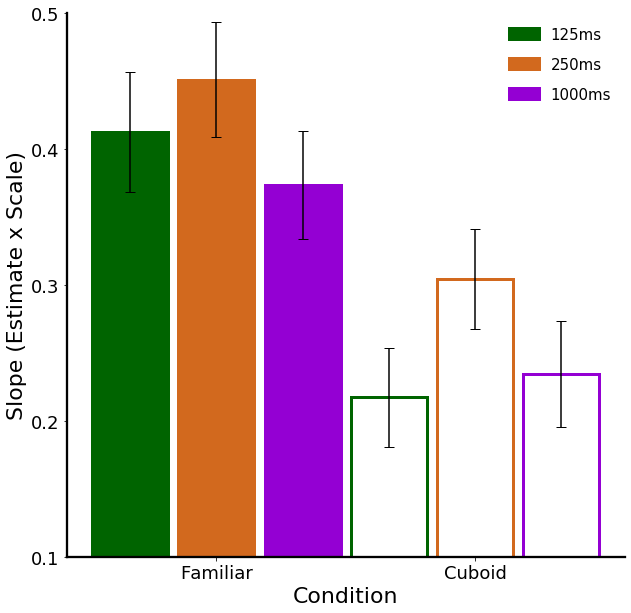

In [19]:
vars = ['fS_125', 'fS_250', 'fs_1000', 'oM_125', 'oM_250', 'oM_1000']
p_slopes = [participant_slopes_125['fS'][0],
            participant_slopes_250['fS'][0],
            participant_slopes_1000['fS'][0],
            participant_slopes_125['oM'][0],
            participant_slopes_250['oM'][0],
            participant_slopes_1000['oM'][0]]

p_sem = [participant_slopes_125['fS'][1],
         participant_slopes_250['fS'][1],
         participant_slopes_1000['fS'][1],
         participant_slopes_125['oM'][1],
         participant_slopes_250['oM'][1],
         participant_slopes_1000['oM'][1]]


fig, ax = plt.subplots(figsize=[10, 10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.3)

# Settings for gaps and bar width
intra_group_gap = 0.02  # Gap between bars within the same group
inter_group_gap = 0.02  # Gap between the two groups (250ms and 1000ms)
bar_width = 0.15
fills = [True, True, False, False]  # No pattern for 1st and 3rd bars, pattern for 2nd and 4th bars

# Calculate positions
num_vars_per_group = 3  # fS and oM in each group
num_groups = len(vars) // num_vars_per_group
positions = []

# Calculate positions for each bar to ensure correct grouping and spacing
for i in range(num_groups):
    group_start = i * (num_vars_per_group * bar_width + (num_vars_per_group - 1) * intra_group_gap + inter_group_gap)
    for j in range(num_vars_per_group):
        pos = group_start + j * (bar_width + intra_group_gap)
        positions.append(pos)

assigned_color = ['darkgreen', 'chocolate','darkviolet', 'darkgreen', 'chocolate', 'darkviolet']
labels = ['125ms','250ms', '1000ms', '','', '']
# Plot bars with adjusted positions
for i, pos in enumerate(positions):
    fill_option = 'none' if i >= 3 else assigned_color[i]  # No fill for last three bars
    ax.bar(pos, p_slopes[i], yerr=p_sem[i], color=None, edgecolor=assigned_color[i], linewidth=3, width=bar_width, capsize=5, facecolor=fill_option, label=labels[i])

# Adjust x-ticks to be in the center of the groups
group_centers = [np.mean(positions[i:i+num_vars_per_group]) for i in range(0, len(positions), num_vars_per_group)]
plt.xticks(group_centers, ['Familiar', 'Cuboid'], fontsize=18)

plt.yticks(fontsize=18)
plt.xlabel("Condition", fontsize=22)
plt.ylabel("Slope (Estimate x Scale)", fontsize=22)

plt.yticks(np.arange(0.1, 0.6, 0.1))
plt.ylim(0.1, 0.5)

legend = plt.legend(loc = 0, fontsize=15, labelspacing=1, frameon=False)

# Export the figure at a high resolution
plt.savefig(fig_destination + '/grouped-by-condition.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution


plt.show()


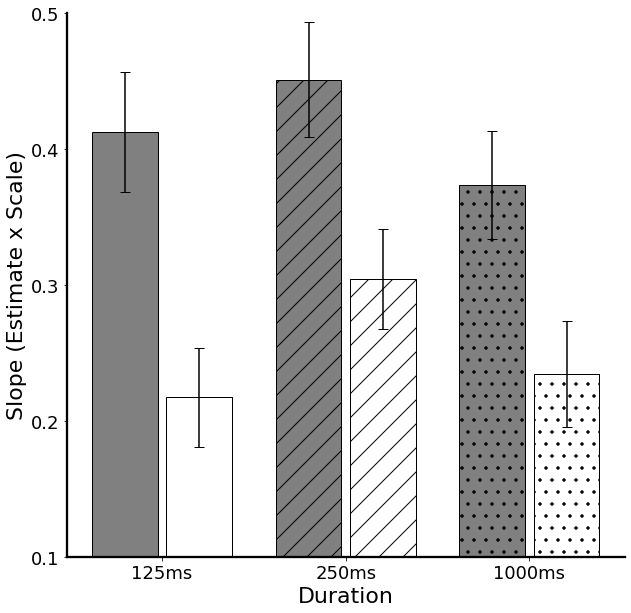

In [135]:
vars = ['fS_125', 'oM_125', 'fS_250', 'oM_250', 'fS_1000', 'oM_1000']
p_slopes = [participant_slopes_125['fS'][0], participant_slopes_125['oM'][0],
            participant_slopes_250['fS'][0], participant_slopes_250['oM'][0], 
            participant_slopes_1000['fS'][0], participant_slopes_1000['oM'][0]]
p_sem = [participant_slopes_125['fS'][1], participant_slopes_125['oM'][1], 
         participant_slopes_250['fS'][1], participant_slopes_250['oM'][1], 
         participant_slopes_1000['fS'][1], participant_slopes_1000['oM'][1]]

fig, ax = plt.subplots(figsize=[10, 10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.3)

# Settings for gaps and bar width
intra_group_gap = 0.02  # Gap between bars within the same group
inter_group_gap = 0.1  # Gap between the two groups (250ms and 1000ms)
bar_width = 0.15
fills = [True, False, True, False, True, False]  # No pattern for 1st and 3rd bars, pattern for 2nd and 4th bars

# Calculate positions
num_vars_per_group = 2  # fS and oM in each group
num_groups = len(vars) // num_vars_per_group
positions = []

# Calculate positions for each bar to ensure correct grouping and spacing
for i in range(num_groups):
    group_start = i * (num_vars_per_group * bar_width + (num_vars_per_group - 1) * intra_group_gap + inter_group_gap)
    for j in range(num_vars_per_group):
        pos = group_start + j * (bar_width + intra_group_gap)
        positions.append(pos)

assigned_color = ['gray', 'gray','gray', 'gray', 'gray', 'gray']
labels = ['125ms', '', '250ms', '', '1000ms', '']
hatching = ['', '', '/', '/', '.', '.']
# Plot bars with adjusted positions
for i, pos in enumerate(positions):
    fill_option = 'none' if i %2 !=0 else assigned_color[i]  # No fill for last three bars
    ax.bar(pos, p_slopes[i], yerr=p_sem[i], color=None, edgecolor='black', linewidth=1, width=bar_width, capsize=5, facecolor=fill_option, label=labels[i], hatch = hatching[i])

# Adjust x-ticks to be in the center of the groups
group_centers = [np.mean(positions[i:i+num_vars_per_group]) for i in range(0, len(positions), num_vars_per_group)]
plt.xticks(group_centers, ['125ms','250ms', '1000ms'], fontsize=18)

plt.yticks(fontsize=18)
plt.xlabel("Duration", fontsize=22)
plt.ylabel("Slope (Estimate x Scale)", fontsize=22)

plt.yticks(np.arange(0.1, 0.6, 0.1))
plt.ylim(0.1, 0.5)

# legend = plt.legend(loc = 1, fontsize=15, labelspacing=1, frameon=False)

# Export the figure at a high resolution
plt.savefig(fig_destination + '/grouped-by-duration.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution

plt.show()

## Condition x Duration

In [21]:
def get_condition_average(cond_df, col):
    avg = cond_df[col].mean()
    sem = stats.sem(np.array(cond_df[col]))

    return avg, sem

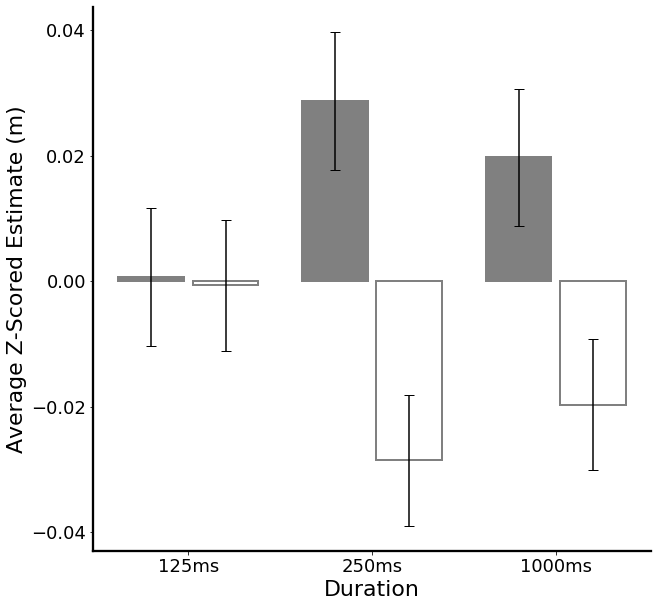

In [110]:
vars = ['fS_125', 'oM_125', 'fS_250', 'oM_250', 'fS_1000', 'oM_1000']
dur_cond_avgs = [get_condition_average(fS_data_125, col)[0], get_condition_average(oM_data_125, col)[0],
                 get_condition_average(fS_data_250, col)[0], get_condition_average(oM_data_250, col)[0],
                 get_condition_average(fS_data_1000, col)[0], get_condition_average(oM_data_1000, col)[0]]
dur_cond_sem = [get_condition_average(fS_data_125, col)[1], get_condition_average(oM_data_125, col)[1],
                 get_condition_average(fS_data_250, col)[1], get_condition_average(oM_data_250, col)[1],
                 get_condition_average(fS_data_1000, col)[1], get_condition_average(oM_data_1000, col)[1]]

fig, ax = plt.subplots(figsize=[10, 10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.3)

# Settings for gaps and bar width
intra_group_gap = 0.02  # Gap between bars within the same group
inter_group_gap = 0.1  # Gap between the two groups (250ms and 1000ms)
bar_width = 0.15
fills = [True, False, True, False, True, False]  # No pattern for 1st and 3rd bars, pattern for 2nd and 4th bars

# Calculate positions
num_vars_per_group = 2  # fS and oM in each group
num_groups = len(vars) // num_vars_per_group
positions = []

# Calculate positions for each bar to ensure correct grouping and spacing
for i in range(num_groups):
    group_start = i * (num_vars_per_group * bar_width + (num_vars_per_group - 1) * intra_group_gap + inter_group_gap)
    for j in range(num_vars_per_group):
        pos = group_start + j * (bar_width + intra_group_gap)
        positions.append(pos)

assigned_color = ['gray', 'gray','gray', 'gray', 'gray', 'gray']
labels = ['125ms', '', '250ms', '', '1000ms', '']
# Plot bars with adjusted positions
for i, pos in enumerate(positions):
    fill_option = 'none' if i %2 !=0 else assigned_color[i]  # No fill for last three bars
    ax.bar(pos, dur_cond_avgs[i], yerr=dur_cond_sem[i], color=None, edgecolor=assigned_color[i], linewidth=2, width=bar_width, capsize=5, facecolor=fill_option, label=labels[i])

# Adjust x-ticks to be in the center of the groups
group_centers = [np.mean(positions[i:i+num_vars_per_group]) for i in range(0, len(positions), num_vars_per_group)]
plt.xticks(group_centers, ['125ms','250ms', '1000ms'], fontsize=18)

plt.yticks(fontsize=18)
plt.xlabel("Duration", fontsize=22)
plt.ylabel("Average Z-Scored Estimate (m)", fontsize=22)

plt.yticks(np.arange(-0.04, 0.06, 0.02))
# plt.ylim(0.1, 0.5)

# legend = plt.legend(loc = 1, fontsize=15, labelspacing=1, frameon=False)

# Export the figure at a high resolution
plt.savefig(fig_destination + '/condition-x-duration.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution

plt.show()

### Condition x Duration: By Participant

In [23]:
def get_participant_averages_per_objectFamiliarity(df, condition, col):
    if condition == 'fS': cond = 'FS'
    if condition == 'oM': cond = 'BC'
    condition_df = df.loc[df['condition']==cond]
    avg = condition_df[col].mean()
    sem = stats.sem(np.array(condition_df[col]))

    return avg, sem

def main_condition_x_duration_byParticipant(df, col):
    conditions = ['fS', 'oM']
    results = {'fS': [], 'oM': []}

    for subj in df.subjID.unique():
        subj_df = df.loc[df['subjID']==subj]
        for condition in conditions:
            results[condition].append(get_participant_averages_per_objectFamiliarity(subj_df, condition,col)[0])

    return results, {'fS': [np.mean(np.array(results['fS'])), stats.sem(np.array(results['fS']))], 'oM': [np.mean(np.array(results['oM'])), stats.sem(np.array(results['oM']))]}

In [24]:
pAvgs_objFamiliarity_125, avg_objFamiliarity_125 = main_condition_x_duration_byParticipant(MX_data_125, 'zs_depth_estimates')
pAvgs_objFamiliarity_250, avg_objFamiliarity_250 = main_condition_x_duration_byParticipant(MX_data_250, 'zs_depth_estimates')
pAvgs_objFamiliarity_1000, avg_objFamiliarity_1000 = main_condition_x_duration_byParticipant(MX_data_1000, 'zs_depth_estimates')

In [25]:

print('DF:',  2-1, len(pAvgs_objFamiliarity_125['fS']) + len(pAvgs_objFamiliarity_125['oM']) - 2)
fvalue, pvalue = stats.f_oneway(pAvgs_objFamiliarity_125['fS'], pAvgs_objFamiliarity_125['oM'])
print(fvalue, pvalue)

print('DF:',  2-1, len(pAvgs_objFamiliarity_250['fS']) + len(pAvgs_objFamiliarity_250['oM']) - 2)
fvalue, pvalue = stats.f_oneway(pAvgs_objFamiliarity_250['fS'], pAvgs_objFamiliarity_250['oM'])
print(fvalue, pvalue)

print('DF:',  2-1, len(pAvgs_objFamiliarity_1000['fS']) + len(pAvgs_objFamiliarity_1000['oM']) - 2)
fvalue, pvalue = stats.f_oneway(pAvgs_objFamiliarity_1000['fS'], pAvgs_objFamiliarity_1000['oM'])
print(fvalue, pvalue)

DF: 1 646
0.008074130042586974 0.9284293685587047
DF: 1 646
24.568279663940466 9.174494580639106e-07
DF: 1 646
11.19141833711447 0.0008693453005480245


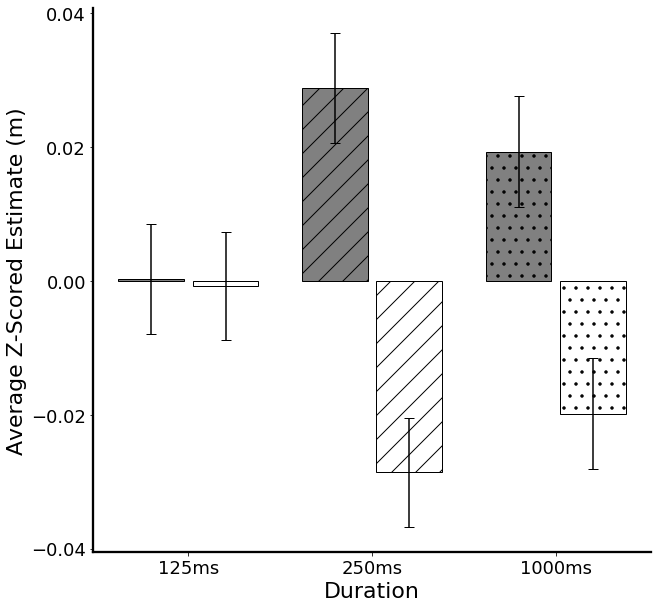

In [137]:
vars = ['fS_125', 'oM_125', 'fS_250', 'oM_250', 'fS_1000', 'oM_1000']
dur_cond_avgs = [avg_objFamiliarity_125['fS'][0],avg_objFamiliarity_125['oM'][0], 
                 avg_objFamiliarity_250['fS'][0], avg_objFamiliarity_250['oM'][0], 
                 avg_objFamiliarity_1000['fS'][0], avg_objFamiliarity_1000['oM'][0]]
dur_cond_sem = [avg_objFamiliarity_125['fS'][1],avg_objFamiliarity_125['oM'][1], 
                 avg_objFamiliarity_250['fS'][1], avg_objFamiliarity_250['oM'][1], 
                 avg_objFamiliarity_1000['fS'][1], avg_objFamiliarity_1000['oM'][1]]

fig, ax = plt.subplots(figsize=[10, 10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.3)

# Settings for gaps and bar width
intra_group_gap = 0.02  # Gap between bars within the same group
inter_group_gap = 0.1  # Gap between the two groups (250ms and 1000ms)
bar_width = 0.15
fills = [True, False, True, False, True, False]  # No pattern for 1st and 3rd bars, pattern for 2nd and 4th bars

# Calculate positions
num_vars_per_group = 2  # fS and oM in each group
num_groups = len(vars) // num_vars_per_group
positions = []

# Calculate positions for each bar to ensure correct grouping and spacing
for i in range(num_groups):
    group_start = i * (num_vars_per_group * bar_width + (num_vars_per_group - 1) * intra_group_gap + inter_group_gap)
    for j in range(num_vars_per_group):
        pos = group_start + j * (bar_width + intra_group_gap)
        positions.append(pos)

assigned_color = ['gray', 'gray','gray', 'gray', 'gray', 'gray']
labels = ['125ms', '', '250ms', '', '1000ms', '']
hatching = ['', '', '/', '/', '.', '.']
# Plot bars with adjusted positions
for i, pos in enumerate(positions):
    fill_option = 'none' if i %2 !=0 else assigned_color[i]  # No fill for last three bars
    # line_option = 2 if i %2 !=0 else 0.2  # No fill for last three bars
    ax.bar(pos, dur_cond_avgs[i], yerr=dur_cond_sem[i], color=None, edgecolor='black', linewidth=1, width=bar_width, capsize=5, facecolor=fill_option, label=labels[i], hatch=hatching[i])

# Adjust x-ticks to be in the center of the groups
group_centers = [np.mean(positions[i:i+num_vars_per_group]) for i in range(0, len(positions), num_vars_per_group)]
plt.xticks(group_centers, ['125ms','250ms', '1000ms'], fontsize=18)

plt.yticks(fontsize=18)
plt.xlabel("Duration", fontsize=22)
plt.ylabel("Average Z-Scored Estimate (m)", fontsize=22)

plt.yticks(np.arange(-0.04, 0.06, 0.02))
# plt.ylim(0.1, 0.5)

# legend = plt.legend(loc = 1, fontsize=15, labelspacing=1, frameon=False)

# Export the figure at a high resolution
plt.savefig(fig_destination + '/condition-x-duration.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution

plt.show()

## Plot LME data

In [27]:
LME_data = pd.read_csv('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/familiarSize/data/LME_interaction.csv')


In [28]:
order = [4, 6, 5, 1, 3, 2, 10, 12, 11, 7, 9, 8, 16, 18, 17, 13, 15, 14] 

LME_data['plotting_order'] = order

LME_data_sorted = LME_data.sort_values(by='plotting_order', ascending=True)



In [29]:
# fig, ax = plt.subplots(figsize=[10,10])
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# for axis in ['bottom','left']:
#     ax.spines[axis].set_linewidth(2.3)
    
# scales =  [a + '_' + b + '_' + str(c) for a, b, c in zip(list(LME_data_sorted['scale']), list(LME_data_sorted['condition']), list(LME_data_sorted['duration']))]
# emmean = list(LME_data_sorted['emmean'])
# errors = list(LME_data_sorted['SE'])

# plt.xticks(fontsize=18, rotation=45)
# plt.yticks(fontsize=18)

# plt.xlabel("Scale", fontsize=22)
# plt.ylabel("LME Estimated Means", fontsize = 22)

    
# # plt.yticks(np.arange(-0.20,0.25, 0.05))

# plt.bar(scales, emmean, yerr = errors, color = ['darkgreen']*6 + ['chocolate']*6 + ['darkviolet']*6, width=0.8, capsize=5)

# plt.title('LME Output', fontsize=25)
# plt.show()

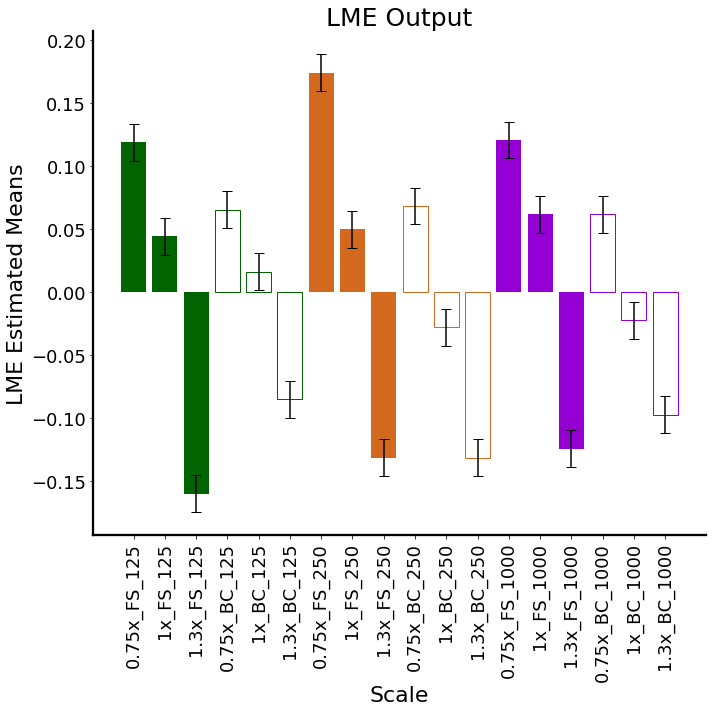

In [30]:
scales =  [a + '_' + b + '_' + str(c) for a, b, c in zip(list(LME_data_sorted['scale']), list(LME_data_sorted['condition']), list(LME_data_sorted['duration']))]
emmean = list(LME_data_sorted['emmean'])
errors = list(LME_data_sorted['SE'])

# Initialize the colors and edgecolors lists
colors = ['none' if (i // 3) % 2 != 0 else 'darkgreen' if i < 6 else 'none' if (i // 3) % 2 != 0 else 'chocolate' if i < 12 else 'none' if (i // 3) % 2 != 0 else 'darkviolet' for i in range(len(scales))]
edgecolors = ['darkgreen' if i < 6 else 'chocolate' if i < 12 else 'darkviolet' for i in range(len(scales))]

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)

plt.xticks(range(len(scales)), scales, fontsize=18, rotation=90)
plt.yticks(fontsize=18)

plt.xlabel("Scale", fontsize=22)
plt.ylabel("LME Estimated Means", fontsize=22)

# Plot bars with alternating fill/no-fill pattern
for i, (scale, em, error) in enumerate(zip(scales, emmean, errors)):
    plt.bar(i, em, yerr=error, color=colors[i], edgecolor=edgecolors[i] if colors[i] == 'none' else 'none', capsize=5)

plt.title('LME Output', fontsize=25)
plt.tight_layout()
plt.show()




# Response Time

In [31]:
RT_col = 'zs_trial_RT'

In [32]:
fvalue, pvalue = stats.f_oneway((np.array(fS_data_125[RT_col])), np.array(oM_data_125[RT_col]))
print(fvalue, pvalue)
fvalue, pvalue = stats.f_oneway((np.array(fS_data_250[RT_col])), (np.array(oM_data_250[RT_col])))
print(fvalue, pvalue)
fvalue, pvalue = stats.f_oneway((np.array(fS_data_1000[RT_col])), (np.array(oM_data_1000[RT_col])))
print(fvalue, pvalue)

1.9828449380028743 0.1591092690416067
18.188398469758067 2.01170825842544e-05
2.3885090124363226 0.12224855283689441


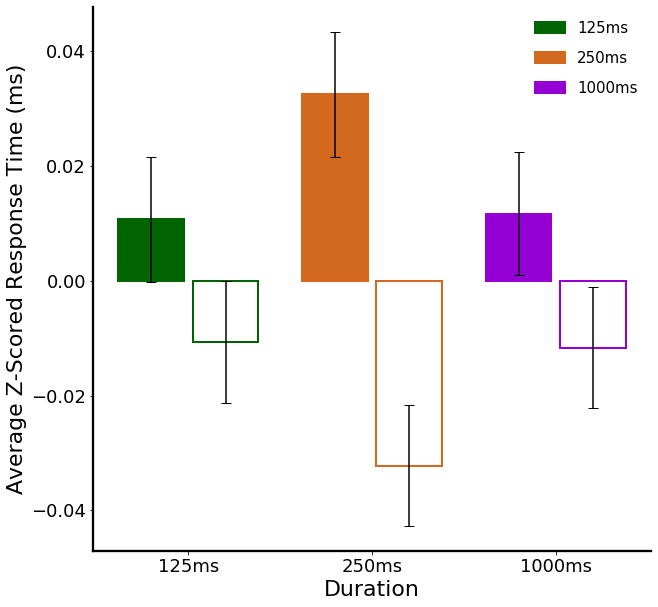

In [33]:
vars = ['fS_125', 'oM_125', 'fS_250', 'oM_250', 'fS_1000', 'oM_1000']
dur_cond_avgs = [get_condition_average(fS_data_125, RT_col)[0], get_condition_average(oM_data_125, RT_col)[0],
                 get_condition_average(fS_data_250, RT_col)[0], get_condition_average(oM_data_250, RT_col)[0],
                 get_condition_average(fS_data_1000, RT_col)[0], get_condition_average(oM_data_1000, RT_col)[0]]
dur_cond_sem = [get_condition_average(fS_data_125, RT_col)[1], get_condition_average(oM_data_125, RT_col)[1],
                 get_condition_average(fS_data_250, RT_col)[1], get_condition_average(oM_data_250, RT_col)[1],
                 get_condition_average(fS_data_1000, RT_col)[1], get_condition_average(oM_data_1000, RT_col)[1]]

fig, ax = plt.subplots(figsize=[10, 10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.3)

# Settings for gaps and bar width
intra_group_gap = 0.02  # Gap between bars within the same group
inter_group_gap = 0.1  # Gap between the two groups (250ms and 1000ms)
bar_width = 0.15
fills = [True, False, True, False, True, False]  # No pattern for 1st and 3rd bars, pattern for 2nd and 4th bars

# Calculate positions
num_vars_per_group = 2  # fS and oM in each group
num_groups = len(vars) // num_vars_per_group
positions = []

# Calculate positions for each bar to ensure correct grouping and spacing
for i in range(num_groups):
    group_start = i * (num_vars_per_group * bar_width + (num_vars_per_group - 1) * intra_group_gap + inter_group_gap)
    for j in range(num_vars_per_group):
        pos = group_start + j * (bar_width + intra_group_gap)
        positions.append(pos)

assigned_color = ['darkgreen', 'darkgreen','chocolate', 'chocolate', 'darkviolet', 'darkviolet']
labels = ['125ms', '', '250ms', '', '1000ms', '']
# Plot bars with adjusted positions
for i, pos in enumerate(positions):
    fill_option = 'none' if i %2 !=0 else assigned_color[i]  # No fill for last three bars
    ax.bar(pos, dur_cond_avgs[i], yerr=dur_cond_sem[i], color=None, edgecolor=assigned_color[i], linewidth=2, width=bar_width, capsize=5, facecolor=fill_option, label=labels[i])

# Adjust x-ticks to be in the center of the groups
group_centers = [np.mean(positions[i:i+num_vars_per_group]) for i in range(0, len(positions), num_vars_per_group)]
plt.xticks(group_centers, ['125ms','250ms', '1000ms'], fontsize=18)

plt.yticks(fontsize=18)
plt.xlabel("Duration", fontsize=22)
plt.ylabel("Average Z-Scored Response Time (ms)", fontsize=22)

plt.yticks(np.arange(-0.04, 0.06, 0.02))
# plt.ylim(0.1, 0.5)

legend = plt.legend(loc = 1, fontsize=15, labelspacing=1, frameon=False)

# Export the figure at a high resolution
plt.savefig(fig_destination + '/RT-condition-x-duration.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution

plt.show()

In [34]:
RT_data_125 = {}
RT_data_125['fS'] = {'0.75x': get_average(fS_data_125, '0.75x', RT_col), '1x': get_average(fS_data_125, '1x', RT_col), '1.3x': get_average(fS_data_125, '1.3x', RT_col)}
RT_data_125['oM'] = {'0.75x': get_average(oM_data_125, '0.75x', RT_col), '1x': get_average(oM_data_125, '1x', RT_col), '1.3x': get_average(oM_data_125, '1.3x', RT_col)}

RT_data_250 = {}
RT_data_250['fS'] = {'0.75x': get_average(fS_data_250, '0.75x', RT_col), '1x': get_average(fS_data_250, '1x', RT_col), '1.3x': get_average(fS_data_250, '1.3x', RT_col)}
RT_data_250['oM'] = {'0.75x': get_average(oM_data_250, '0.75x', RT_col), '1x': get_average(oM_data_250, '1x', RT_col), '1.3x': get_average(oM_data_250, '1.3x', RT_col)}

RT_data_1000 = {}
RT_data_1000['fS'] = {'0.75x': get_average(fS_data_1000, '0.75x', RT_col), '1x': get_average(fS_data_1000, '1x', RT_col), '1.3x': get_average(fS_data_1000, '1.3x', RT_col)}
RT_data_1000['oM'] = {'0.75x': get_average(oM_data_1000, '0.75x', RT_col), '1x': get_average(oM_data_1000, '1x', RT_col), '1.3x': get_average(oM_data_1000, '1.3x', RT_col)}

No handles with labels found to put in legend.


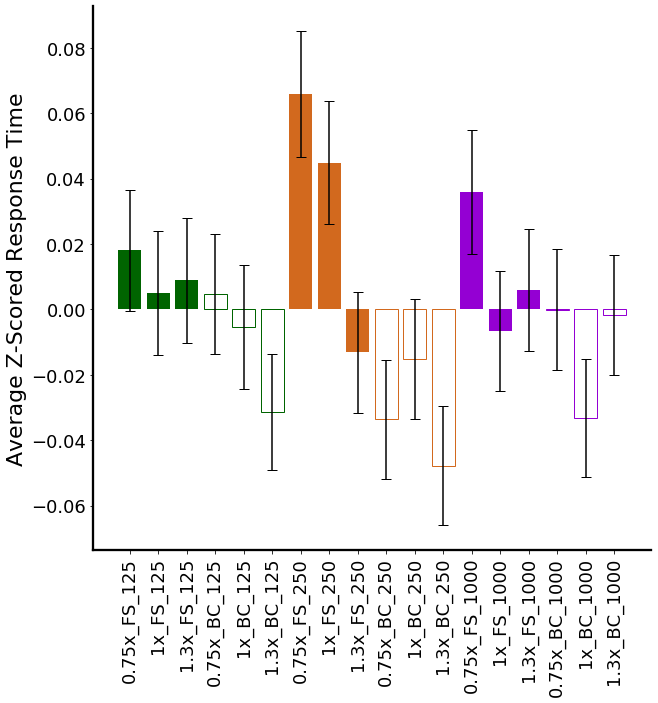

In [35]:
vars = [a + '_' + b + '_' + str(c) for a, b, c in zip(list(LME_data_sorted['scale']), list(LME_data_sorted['condition']), list(LME_data_sorted['duration']))]

RT_averages = [RT_data_125['fS']['0.75x'][0], RT_data_125['fS']['1x'][0], RT_data_125['fS']['1.3x'][0],
               RT_data_125['oM']['0.75x'][0], RT_data_125['oM']['1x'][0], RT_data_125['oM']['1.3x'][0],
               RT_data_250['fS']['0.75x'][0], RT_data_250['fS']['1x'][0], RT_data_250['fS']['1.3x'][0],
               RT_data_250['oM']['0.75x'][0], RT_data_250['oM']['1x'][0], RT_data_250['oM']['1.3x'][0],
               RT_data_1000['fS']['0.75x'][0], RT_data_1000['fS']['1x'][0], RT_data_1000['fS']['1.3x'][0],
               RT_data_1000['oM']['0.75x'][0], RT_data_1000['oM']['1x'][0], RT_data_1000['oM']['1.3x'][0]]

RT_sem = [RT_data_125['fS']['0.75x'][1], RT_data_125['fS']['1x'][1], RT_data_125['fS']['1.3x'][1],
          RT_data_125['oM']['0.75x'][1], RT_data_125['oM']['1x'][1], RT_data_125['oM']['1.3x'][1],
          RT_data_250['fS']['0.75x'][1], RT_data_250['fS']['1x'][1], RT_data_250['fS']['1.3x'][1],
          RT_data_250['oM']['0.75x'][1], RT_data_250['oM']['1x'][1], RT_data_250['oM']['1.3x'][1],
          RT_data_1000['fS']['0.75x'][1], RT_data_1000['fS']['1x'][1], RT_data_1000['fS']['1.3x'][1],
          RT_data_1000['oM']['0.75x'][1], RT_data_1000['oM']['1x'][1], RT_data_1000['oM']['1.3x'][1]]

fig, ax = plt.subplots(figsize=[10, 10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.3)

plt.xticks(range(len(scales)), scales, fontsize=18, rotation=90)
plt.yticks(fontsize=18)

# plt.xlabel("Scale", fontsize=22)
plt.ylabel("Average Z-Scored Response Time", fontsize=22)

# Plot bars with alternating fill/no-fill pattern
for i, (scale, em, error) in enumerate(zip(vars, RT_averages, RT_sem)):
    plt.bar(i, em, yerr=error, color=colors[i], edgecolor=edgecolors[i] if colors[i] == 'none' else 'none', capsize=5)


legend = plt.legend(loc = 1, fontsize=15, labelspacing=1, frameon=False)

# Export the figure at a high resolution
plt.savefig(fig_destination + '/RT-by-duration.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution

plt.show()

## Main effect of scale: collapse by duration and plot three scales

In [36]:
all_dur_data = pd.concat([MX_data_125, MX_data_250, MX_data_1000])

3.524531995572709 0.029472729632454522
2.4628484990061397 0.1165764736067512
6.973987436721372 0.00827405807779289
1.1389363591160075 0.2858847232157743


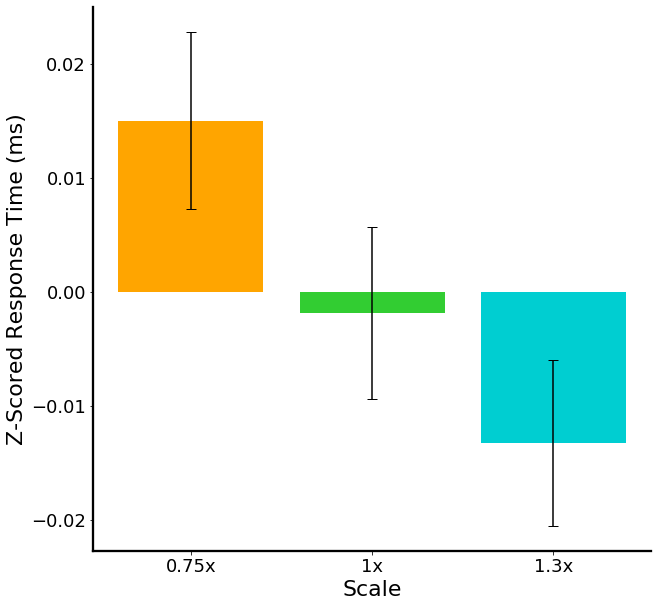

In [37]:

data_sm = all_dur_data.loc[all_dur_data['scale']=='0.75x']
data_can = all_dur_data.loc[all_dur_data['scale']=='1x']
data_lg = all_dur_data.loc[all_dur_data['scale']=='1.3x']

avg_sm = data_sm[RT_col].mean()
avg_can = data_can[RT_col].mean()
avg_lg = data_lg[RT_col].mean()

ste_sm = stats.sem(np.array(data_sm[col]))
ste_can = stats.sem(np.array(data_can[col]))
ste_lg = stats.sem(np.array(data_lg[col]))

# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(data_sm[RT_col], data_can[RT_col], data_lg[RT_col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(data_sm[RT_col], data_can[RT_col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(data_sm[RT_col], data_lg[RT_col])
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(data_can[RT_col], data_lg[RT_col])
print(fvalue, pvalue)

fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
scales = ['0.75x', '1x', '1.3x']
RT_averages = [avg_sm, avg_can, avg_lg]
RT_sem = [ste_sm, ste_can, ste_lg]

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel("Scale", fontsize=22)
plt.ylabel("Z-Scored Response Time (ms)", fontsize = 22)


plt.bar(scales, RT_averages, yerr = RT_sem, color = ['orange', 'limegreen', 'darkturquoise'], width=0.8, capsize=5)

# plt.title('Familiar', fontsize=25)

# Export the figure at a high resolution
# plt.savefig(fig_destination + '/scale-avgEstims.png', dpi=300)  # Adjust the dpi value as needed for higher or lower resolution

plt.show()

## Main effect of AD and ED: plot the regressions 

AD x RT
ED x RT

In [38]:
trial_pivot_all_dur = trial_pivotTable(all_dur_data, col, RT_col)

trial_final_all_dur = trial_getxy(trial_pivot_all_dur)

results_all_dur = {}

results_all_dur['stimuli'] = trial_final_all_dur[0]
results_all_dur['y'] = trial_final_all_dur[1]
results_all_dur['ste'] = trial_final_all_dur[2]
results_all_dur['x'] = trial_final_all_dur[3]
results_all_dur['std'] = trial_final_all_dur[4]
results_all_dur['RT'] = trial_final_all_dur[5]
results_all_dur['RT_ste'] = trial_final_all_dur[6]
results_all_dur['zs_actual_depth'] = (np.array(results_all_dur['x']) - np.mean(np.array(results_all_dur['x'])))/np.std(np.array(results_all_dur['x']))

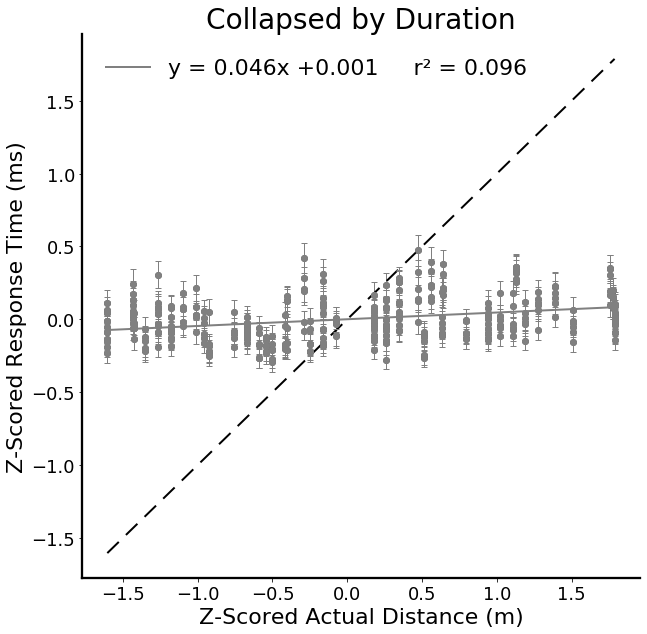

In [39]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
X = np.array(results_all_dur['zs_actual_depth']).reshape(-1,1)
y = results_all_dur['RT']
ste = results_all_dur['RT_ste']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)


plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='gray', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("Collapsed by Duration", fontsize = 28)

plt.xlabel("Z-Scored Actual Distance (m)", fontsize = 22)
plt.ylabel("Z-Scored Response Time (ms)", fontsize = 22)

dash_pattern = [8, 5]
plt.plot(X, X, color='black', linestyle='--', dashes=dash_pattern, linewidth=2)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "gray", mec = "gray", capsize = 3)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

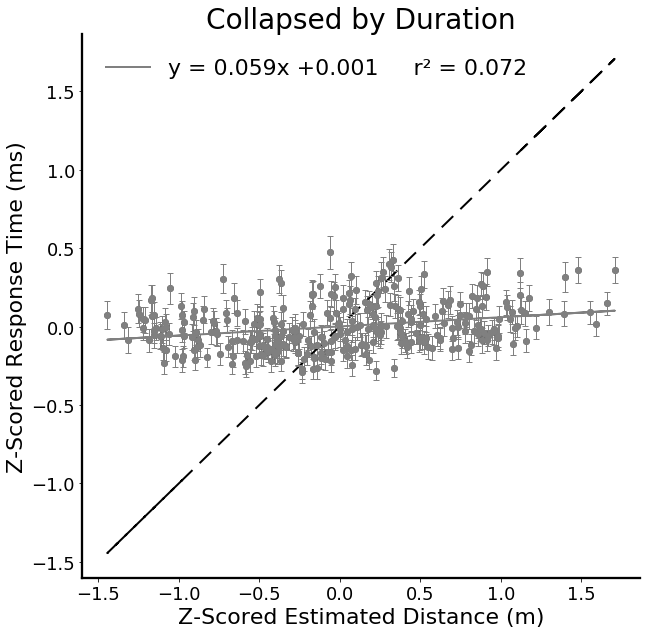

In [40]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
X = np.array(results_all_dur['y']).reshape(-1,1)
y = results_all_dur['RT']
ste = results_all_dur['RT_ste']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)


plt.plot(X, y, 'o', color='black', alpha = 0.5)
plt.plot(X,y_predicted,color='gray', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)
plt.title("Collapsed by Duration", fontsize = 28)

plt.xlabel("Z-Scored Estimated Distance (m)", fontsize = 22)
plt.ylabel("Z-Scored Response Time (ms)", fontsize = 22)

dash_pattern = [8, 5]
plt.plot(X, X, color='black', linestyle='--', dashes=dash_pattern, linewidth=2)
plt.errorbar(X, y, yerr=ste, elinewidth = 1, ecolor = "gray", fmt = 'or', mfc = "gray", mec = "gray", capsize = 3)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

legend = plt.legend(loc = 2, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)

# Residuals Matrix

In [41]:
import pickle

all_data = {}
results_path = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/familiarSize/data/results'
for file in os.listdir(results_path):
    if 'pkl' in file:
        # Path to the pickle file you want to read
        pickle_file_path = results_path + '/' + file

        # Reading from the pickle file
        with open(pickle_file_path, 'rb') as pickle_file:
            my_dict = pickle.load(pickle_file)
        all_data[file.split('.pkl')[0]] = my_dict


In [42]:
all_data.keys()

dict_keys(['250_fS_1x', '125_oM_0.75x', '1000_oM_1.3x', '250_fS_0.75x', '1000_oM_1x', '125_fS_1.3x', '250_fS_1.3x', '250_oM_1x', '1000_fS_0.75x', '1000_fS_1x', '250_oM_0.75x', '125_fS_0.75x', '125_oM_1x', '1000_fS_1.3x', '125_oM_1.3x', '250_oM_1.3x', '1000_oM_0.75x', '125_fS_1x'])

In [43]:
all_resid = {'125_fS_0.75x': all_data['125_fS_0.75x']['residuals'],
             '125_fS_1x': all_data['125_fS_1x']['residuals'],
             '125_fS_1.3x': all_data['125_fS_1.3x']['residuals'],
             '125_oM_0.75x': all_data['125_oM_0.75x']['residuals'],
             '125_oM_1x': all_data['125_oM_1x']['residuals'],
             '125_oM_1.3x': all_data['125_oM_1.3x']['residuals'],
             '250_fS_0.75x': all_data['250_fS_0.75x']['residuals'],
             '250_fS_1x': all_data['250_fS_1x']['residuals'],
             '250_fS_1.3x': all_data['250_fS_1.3x']['residuals'],
             '250_oM_0.75x': all_data['250_oM_0.75x']['residuals'],
             '250_oM_1x': all_data['250_oM_1x']['residuals'],
             '250_oM_1.3x': all_data['250_oM_1.3x']['residuals'],
             '1000_fS_0.75x': all_data['1000_fS_0.75x']['residuals'],
             '1000_fS_1x': all_data['1000_fS_1x']['residuals'],
             '1000_fS_1.3x': all_data['1000_fS_1.3x']['residuals'],
             '1000_oM_0.75x': all_data['1000_oM_0.75x']['residuals'],
             '1000_oM_1x': all_data['1000_oM_1x']['residuals'],
             '1000_oM_1.3x': all_data['1000_oM_1.3x']['residuals']
            }

all_resid_df = pd.DataFrame(all_resid,columns=list(all_resid.keys()))

all_resid_df_corr = all_resid_df.corr()

<Figure size 1080x1080 with 0 Axes>

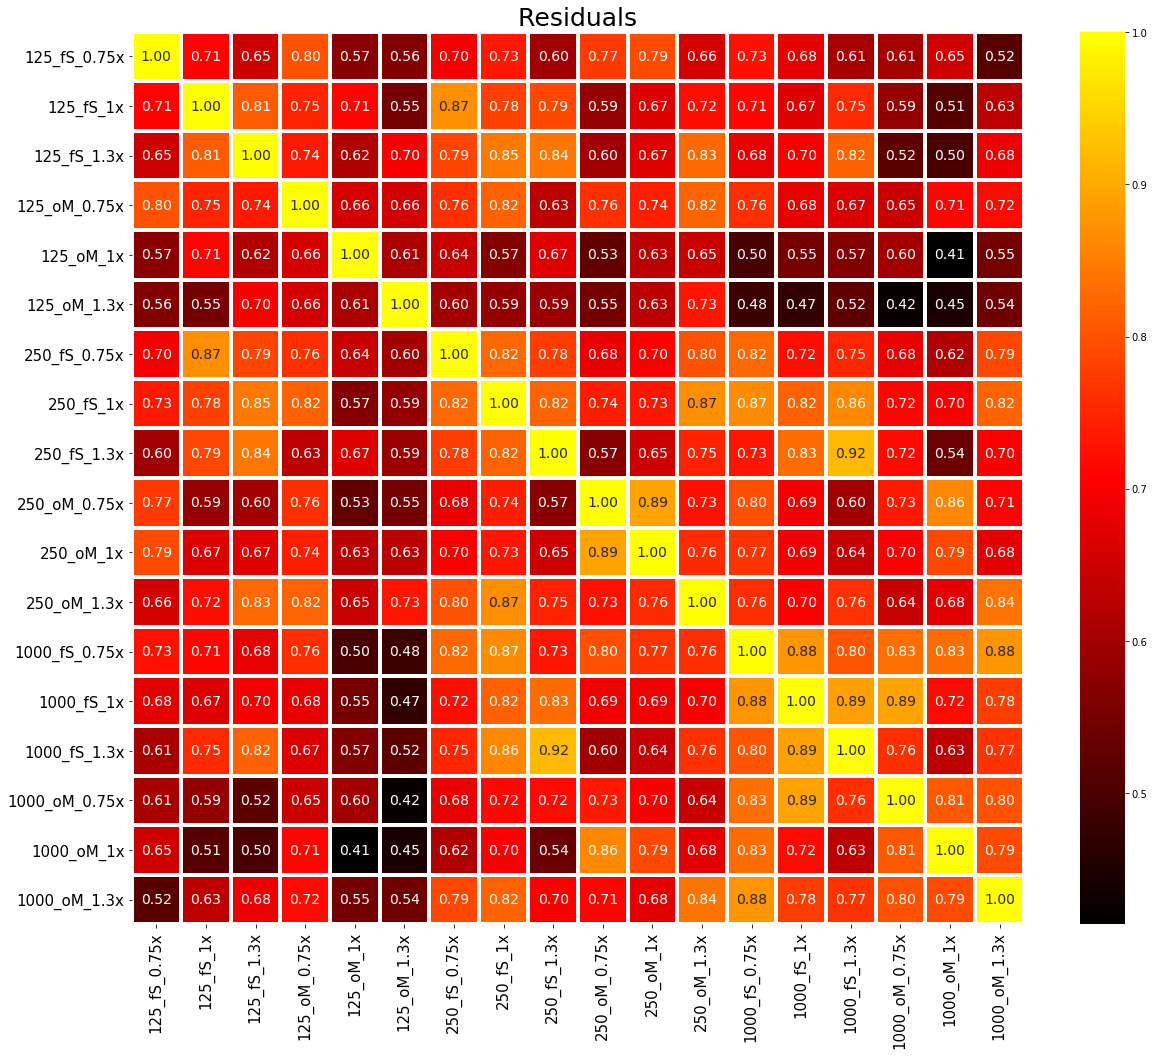

In [44]:
import seaborn as sns
import matplotlib.colors
import matplotlib.colors as mcolors


plt.figure(figsize=[15,15])

# Custom colormap from black to yellow
colors = ["black", "red", "yellow"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# Normalize the color mapping to start at 0.5 instead of 0
norm = mcolors.Normalize(vmin=0.5, vmax=1)

plt.figure(figsize=[20,20])

# Create the heatmap with normalization
ax = sns.heatmap(all_resid_df_corr, annot=True, fmt=".2f", cmap=cmap, norm=norm, square=True, edgecolors='w', linewidths=3, cbar_kws={"shrink": .82}, annot_kws={"size": 14})

# Adjust the axis limits if necessary
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust font size here

plt.title('Residuals', fontsize=25)

plt.savefig(fig_destination + '/residuals-matrix.png', dpi=300)

plt.show();

In [45]:
all_resid = {'125_fS_0.75x': all_data['125_fS_0.75x']['residuals'],
             '125_fS_1x': all_data['125_fS_1x']['residuals'],
             '125_fS_1.3x': all_data['125_fS_1.3x']['residuals'],
             '250_fS_0.75x': all_data['250_fS_0.75x']['residuals'],
             '250_fS_1x': all_data['250_fS_1x']['residuals'],
             '250_fS_1.3x': all_data['250_fS_1.3x']['residuals'],
             '1000_fS_0.75x': all_data['1000_fS_0.75x']['residuals'],
             '1000_fS_1x': all_data['1000_fS_1x']['residuals'],
             '1000_fS_1.3x': all_data['1000_fS_1.3x']['residuals'],
             '125_oM_0.75x': all_data['125_oM_0.75x']['residuals'],
             '125_oM_1x': all_data['125_oM_1x']['residuals'],
             '125_oM_1.3x': all_data['125_oM_1.3x']['residuals'],
             '250_oM_0.75x': all_data['250_oM_0.75x']['residuals'],
             '250_oM_1x': all_data['250_oM_1x']['residuals'],
             '250_oM_1.3x': all_data['250_oM_1.3x']['residuals'],
             '1000_oM_0.75x': all_data['1000_oM_0.75x']['residuals'],
             '1000_oM_1x': all_data['1000_oM_1x']['residuals'],
             '1000_oM_1.3x': all_data['1000_oM_1.3x']['residuals']
            }

all_resid_df = pd.DataFrame(all_resid,columns=list(all_resid.keys()))

all_resid_df_corr = all_resid_df.corr()

In [46]:
all_resid_df_corr

,125_fS_0.75x,125_fS_1x,125_fS_1.3x,250_fS_0.75x,250_fS_1x,250_fS_1.3x,1000_fS_0.75x,1000_fS_1x,1000_fS_1.3x,125_oM_0.75x,125_oM_1x,125_oM_1.3x,250_oM_0.75x,250_oM_1x,250_oM_1.3x,1000_oM_0.75x,1000_oM_1x,1000_oM_1.3x
125_fS_0.75x,1.000000,0.708917,0.649762,0.695246,0.733795,0.598346,0.727356,0.677373,0.608755,0.800513,0.572920,0.564648,0.772934,0.792692,0.658895,0.605715,0.651363,0.515756
125_fS_1x,0.708917,1.000000,0.810590,0.870799,0.782393,0.787292,0.714911,0.669671,0.754888,0.747717,0.709590,0.549820,0.586930,0.666191,0.722649,0.585509,0.514458,0.629395
125_fS_1.3x,0.649762,0.810590,1.000000,0.785042,0.845514,0.842450,0.677605,0.697427,0.817393,0.735790,0.617555,0.695904,0.599993,0.671471,0.826458,0.521694,0.500337,0.684960
250_fS_0.75x,0.695246,0.870799,0.785042,1.000000,0.824736,0.777210,0.824310,0.721914,0.748860,0.761074,0.642495,0.602886,0.680291,0.703447,0.799149,0.679232,0.616380,0.788795
250_fS_1x,0.733795,0.782393,0.845514,0.824736,1.000000,0.821207,0.866060,0.818827,0.861168,0.817125,0.567111,0.585530,0.740450,0.731690,0.871059,0.715506,0.702433,0.819626
250_fS_1.3x,0.598346,0.787292,0.842450,0.777210,0.821207,1.000000,0.731442,0.831919,0.918498,0.630419,0.671562,0.592079,0.570354,0.649022,0.745223,0.717860,0.538161,0.702795
1000_fS_0.75x,0.727356,0.714911,0.677605,0.824310,0.866060,0.731442,1.000000,0.877469,0.804439,0.758779,0.497608,0.484543,0.797489,0.765674,0.758810,0.834907,0.832701,0.876683
1000_fS_1x,0.677373,0.669671,0.697427,0.721914,0.818827,0.831919,0.877469,1.000000,0.891327,0.679126,0.550282,0.473436,0.693251,0.691139,0.701270,0.893901,0.717902,0.776778
1000_fS_1.3x,0.608755,0.754888,0.817393,0.748860,0.861168,0.918498,0.804439,0.891327,1.000000,0.667367,0.565128,0.523897,0.598047,0.640671,0.762652,0.761660,0.630719,0.765439
125_oM_0.75x,0.800513,0.747717,0.735790,0.761074,0.817125,0.630419,0.758779,0.679126,0.667367,1.000000,0.657312,0.656696,0.761507,0.743551,0.819765,0.646713,0.712994,0.716695


<Figure size 1080x1080 with 0 Axes>

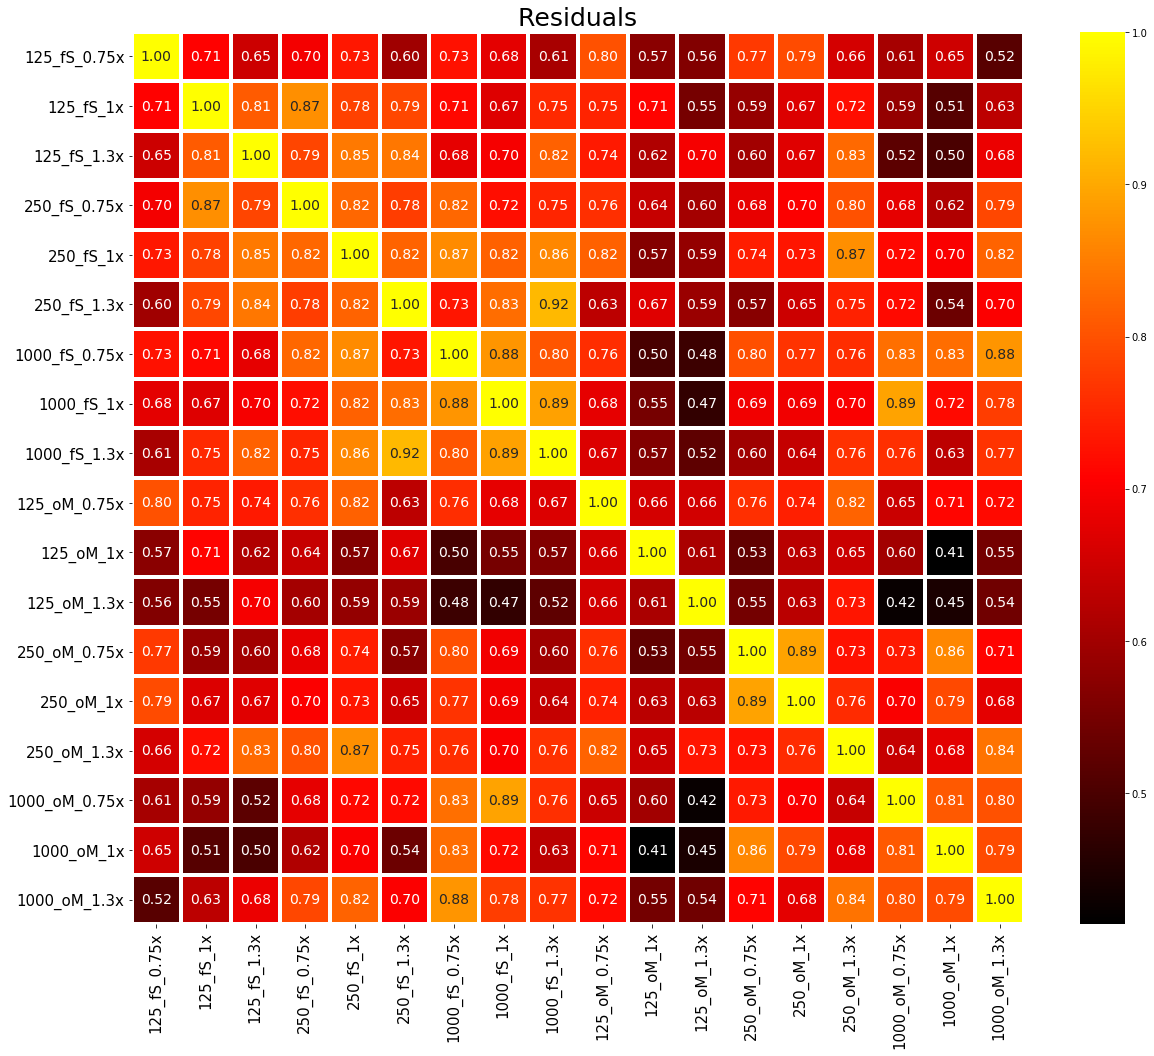

In [47]:
import seaborn as sns
import matplotlib.colors
import matplotlib.colors as mcolors


plt.figure(figsize=[15,15])

# Custom colormap from black to yellow
colors = ["black", "red", "yellow"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# Normalize the color mapping to start at 0.5 instead of 0
norm = mcolors.Normalize(vmin=0.5, vmax=1)

plt.figure(figsize=[20,20])

# Create the heatmap with normalization
ax = sns.heatmap(all_resid_df_corr, annot=True, fmt=".2f", cmap=cmap, norm=norm, square=True, edgecolors='w', linewidths=3, cbar_kws={"shrink": .82}, annot_kws={"size": 14})

# Adjust the axis limits if necessary
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust font size here

plt.title('Residuals', fontsize=25)

plt.savefig(fig_destination + '/residuals-matrix-v2.png', dpi=300)

plt.show();

In [48]:
import pandas as pd
import numpy as np

# Replace all cells equal to 1 with NaN
df_replaced = all_resid_df_corr.replace(1, np.nan)


<Figure size 1080x1080 with 0 Axes>

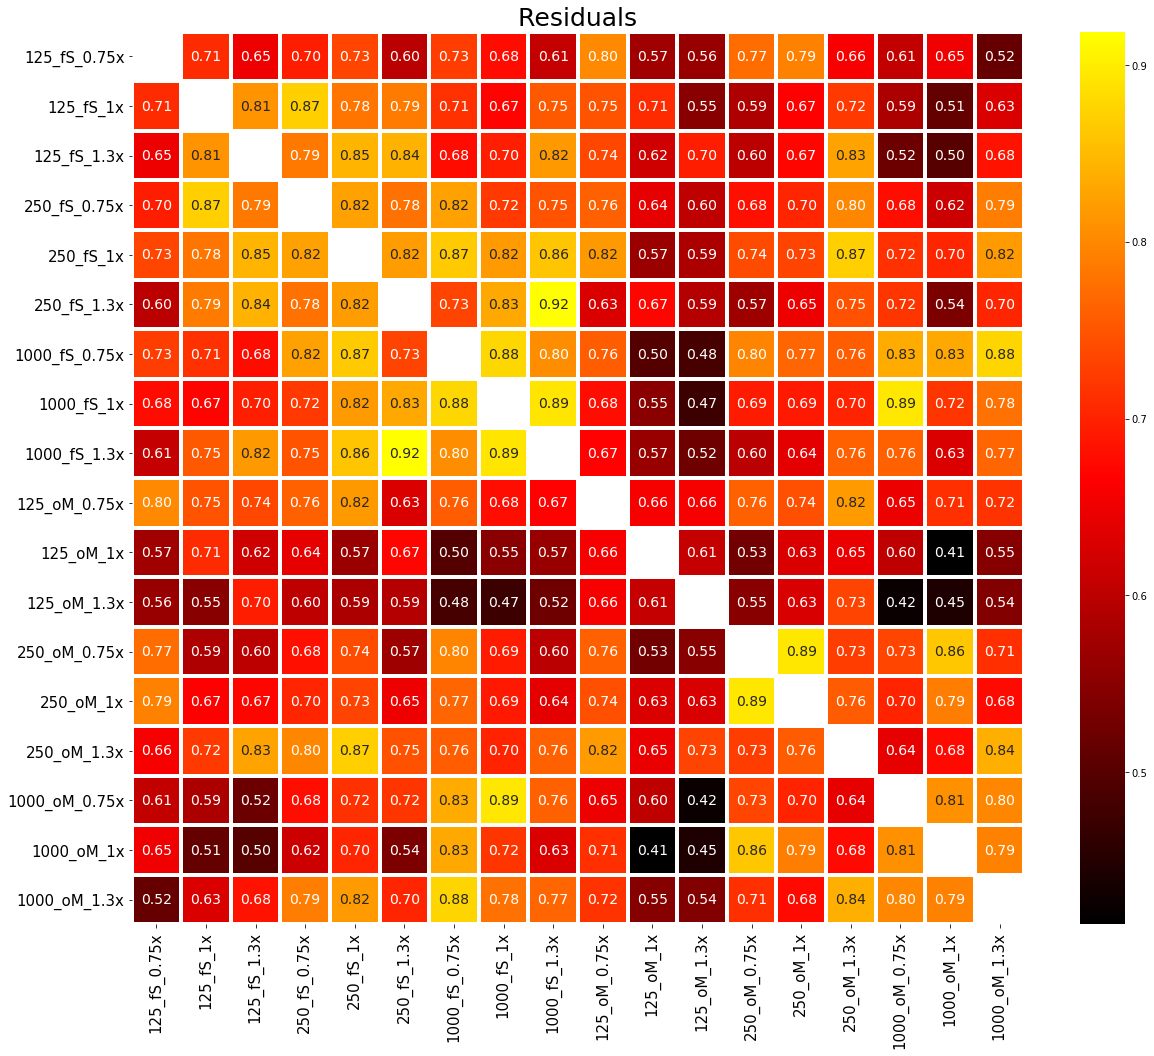

In [49]:
import seaborn as sns
import matplotlib.colors
import matplotlib.colors as mcolors


plt.figure(figsize=[15,15])

# Custom colormap from black to yellow
colors = ["black", "red", "yellow"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# Normalize the color mapping to start at 0.5 instead of 0
norm = mcolors.Normalize(vmin=0.5, vmax=1)

plt.figure(figsize=[20,20])

# Create the heatmap with normalization
ax = sns.heatmap(df_replaced, annot=True, fmt=".2f", cmap=cmap, norm=norm, square=True, edgecolors='w', linewidths=3, cbar_kws={"shrink": .82}, annot_kws={"size": 14})

# Adjust the axis limits if necessary
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust font size here

plt.title('Residuals', fontsize=25)

plt.savefig(fig_destination + '/residuals-matrix-v3.png', dpi=300)

plt.show();

In [139]:
all_resid = {'125_fS_0.75x': all_data['125_fS_0.75x']['residuals'],
             '250_fS_0.75x': all_data['250_fS_0.75x']['residuals'],
             '1000_fS_0.75x': all_data['1000_fS_0.75x']['residuals'],
             '125_fS_1x': all_data['125_fS_1x']['residuals'],
             '250_fS_1x': all_data['250_fS_1x']['residuals'],
             '1000_fS_1x': all_data['1000_fS_1x']['residuals'],
             '125_fS_1.3x': all_data['125_fS_1.3x']['residuals'],
             '250_fS_1.3x': all_data['250_fS_1.3x']['residuals'],
             '1000_fS_1.3x': all_data['1000_fS_1.3x']['residuals'],
             '125_oM_0.75x': all_data['125_oM_0.75x']['residuals'],
             '250_oM_0.75x': all_data['250_oM_0.75x']['residuals'],
             '1000_oM_0.75x': all_data['1000_oM_0.75x']['residuals'],
             '125_oM_1x': all_data['125_oM_1x']['residuals'],
             '250_oM_1x': all_data['250_oM_1x']['residuals'],
             '1000_oM_1x': all_data['1000_oM_1x']['residuals'],
             '125_oM_1.3x': all_data['125_oM_1.3x']['residuals'],
             '250_oM_1.3x': all_data['250_oM_1.3x']['residuals'],
             '1000_oM_1.3x': all_data['1000_oM_1.3x']['residuals']
            }

all_resid_df = pd.DataFrame(all_resid,columns=list(all_resid.keys()))

all_resid_df_corr = all_resid_df.corr()


df_replaced = all_resid_df_corr.replace(1, np.nan)

all_resid_df_corr.to_csv('matrix-v4.csv', index=True)


In [143]:
df_replaced

,125_fS_0.75x,250_fS_0.75x,1000_fS_0.75x,125_fS_1x,250_fS_1x,1000_fS_1x,125_fS_1.3x,250_fS_1.3x,1000_fS_1.3x,125_oM_0.75x,250_oM_0.75x,1000_oM_0.75x,125_oM_1x,250_oM_1x,1000_oM_1x,125_oM_1.3x,250_oM_1.3x,1000_oM_1.3x
125_fS_0.75x,NaN,0.695246,0.727356,0.708917,0.733795,0.677373,0.649762,0.598346,0.608755,0.800513,0.772934,0.605715,0.572920,0.792692,0.651363,0.564648,0.658895,0.515756
250_fS_0.75x,0.695246,NaN,0.824310,0.870799,0.824736,0.721914,0.785042,0.777210,0.748860,0.761074,0.680291,0.679232,0.642495,0.703447,0.616380,0.602886,0.799149,0.788795
1000_fS_0.75x,0.727356,0.824310,NaN,0.714911,0.866060,0.877469,0.677605,0.731442,0.804439,0.758779,0.797489,0.834907,0.497608,0.765674,0.832701,0.484543,0.758810,0.876683
125_fS_1x,0.708917,0.870799,0.714911,NaN,0.782393,0.669671,0.810590,0.787292,0.754888,0.747717,0.586930,0.585509,0.709590,0.666191,0.514458,0.549820,0.722649,0.629395
250_fS_1x,0.733795,0.824736,0.866060,0.782393,NaN,0.818827,0.845514,0.821207,0.861168,0.817125,0.740450,0.715506,0.567111,0.731690,0.702433,0.585530,0.871059,0.819626
1000_fS_1x,0.677373,0.721914,0.877469,0.669671,0.818827,NaN,0.697427,0.831919,0.891327,0.679126,0.693251,0.893901,0.550282,0.691139,0.717902,0.473436,0.701270,0.776778
125_fS_1.3x,0.649762,0.785042,0.677605,0.810590,0.845514,0.697427,NaN,0.842450,0.817393,0.735790,0.599993,0.521694,0.617555,0.671471,0.500337,0.695904,0.826458,0.684960
250_fS_1.3x,0.598346,0.777210,0.731442,0.787292,0.821207,0.831919,0.842450,NaN,0.918498,0.630419,0.570354,0.717860,0.671562,0.649022,0.538161,0.592079,0.745223,0.702795
1000_fS_1.3x,0.608755,0.748860,0.804439,0.754888,0.861168,0.891327,0.817393,0.918498,NaN,0.667367,0.598047,0.761660,0.565128,0.640671,0.630719,0.523897,0.762652,0.765439
125_oM_0.75x,0.800513,0.761074,0.758779,0.747717,0.817125,0.679126,0.735790,0.630419,0.667367,NaN,0.761507,0.646713,0.657312,0.743551,0.712994,0.656696,0.819765,0.716695


In [144]:
df_replaced['125_fS_0.75x']['125_fS_0.75x'] = 0.27

In [145]:
df_replaced

,125_fS_0.75x,250_fS_0.75x,1000_fS_0.75x,125_fS_1x,250_fS_1x,1000_fS_1x,125_fS_1.3x,250_fS_1.3x,1000_fS_1.3x,125_oM_0.75x,250_oM_0.75x,1000_oM_0.75x,125_oM_1x,250_oM_1x,1000_oM_1x,125_oM_1.3x,250_oM_1.3x,1000_oM_1.3x
125_fS_0.75x,0.270000,0.695246,0.727356,0.708917,0.733795,0.677373,0.649762,0.598346,0.608755,0.800513,0.772934,0.605715,0.572920,0.792692,0.651363,0.564648,0.658895,0.515756
250_fS_0.75x,0.695246,NaN,0.824310,0.870799,0.824736,0.721914,0.785042,0.777210,0.748860,0.761074,0.680291,0.679232,0.642495,0.703447,0.616380,0.602886,0.799149,0.788795
1000_fS_0.75x,0.727356,0.824310,NaN,0.714911,0.866060,0.877469,0.677605,0.731442,0.804439,0.758779,0.797489,0.834907,0.497608,0.765674,0.832701,0.484543,0.758810,0.876683
125_fS_1x,0.708917,0.870799,0.714911,NaN,0.782393,0.669671,0.810590,0.787292,0.754888,0.747717,0.586930,0.585509,0.709590,0.666191,0.514458,0.549820,0.722649,0.629395
250_fS_1x,0.733795,0.824736,0.866060,0.782393,NaN,0.818827,0.845514,0.821207,0.861168,0.817125,0.740450,0.715506,0.567111,0.731690,0.702433,0.585530,0.871059,0.819626
1000_fS_1x,0.677373,0.721914,0.877469,0.669671,0.818827,NaN,0.697427,0.831919,0.891327,0.679126,0.693251,0.893901,0.550282,0.691139,0.717902,0.473436,0.701270,0.776778
125_fS_1.3x,0.649762,0.785042,0.677605,0.810590,0.845514,0.697427,NaN,0.842450,0.817393,0.735790,0.599993,0.521694,0.617555,0.671471,0.500337,0.695904,0.826458,0.684960
250_fS_1.3x,0.598346,0.777210,0.731442,0.787292,0.821207,0.831919,0.842450,NaN,0.918498,0.630419,0.570354,0.717860,0.671562,0.649022,0.538161,0.592079,0.745223,0.702795
1000_fS_1.3x,0.608755,0.748860,0.804439,0.754888,0.861168,0.891327,0.817393,0.918498,NaN,0.667367,0.598047,0.761660,0.565128,0.640671,0.630719,0.523897,0.762652,0.765439
125_oM_0.75x,0.800513,0.761074,0.758779,0.747717,0.817125,0.679126,0.735790,0.630419,0.667367,NaN,0.761507,0.646713,0.657312,0.743551,0.712994,0.656696,0.819765,0.716695


<Figure size 1080x1080 with 0 Axes>

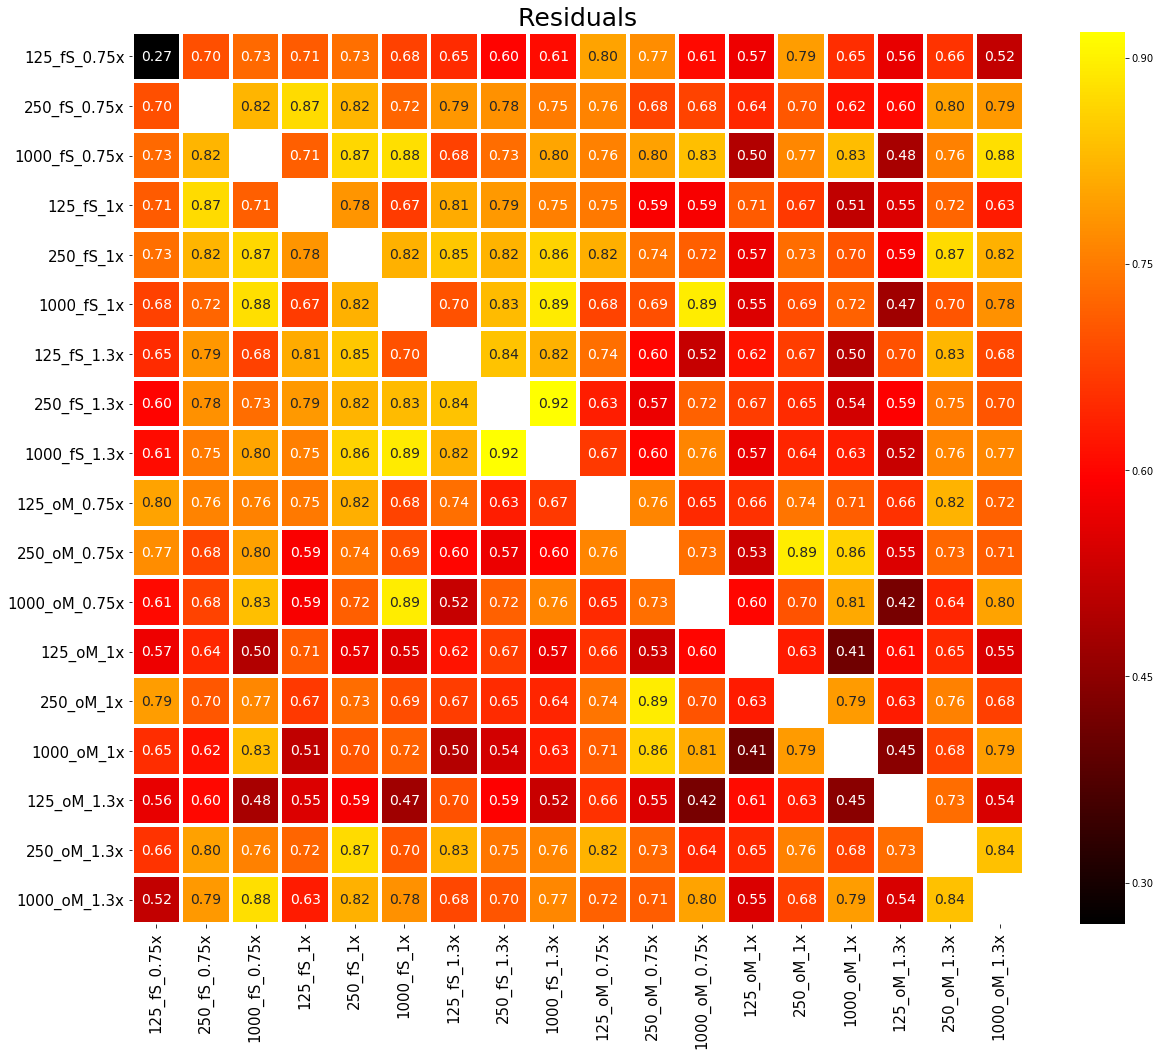

In [146]:
import seaborn as sns
import matplotlib.colors
import matplotlib.colors as mcolors


plt.figure(figsize=[15,15])

# Custom colormap from black to yellow
colors = ["black", "red", "yellow"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# Normalize the color mapping to start at 0.5 instead of 0
norm = mcolors.Normalize(vmin=0.5, vmax=1)

plt.figure(figsize=[20,20])

# Create the heatmap with normalization
ax = sns.heatmap(df_replaced, annot=True, fmt=".2f", cmap=cmap, norm=norm, square=True, edgecolors='w', linewidths=3, cbar_kws={"shrink": .82}, annot_kws={"size": 14})

# Adjust the axis limits if necessary
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust font size here

plt.title('Residuals', fontsize=25)

plt.savefig(fig_destination + '/residuals-matrix-v4.png', dpi=300)

plt.show();

#### Average over duration correlations

In [147]:
dur_collapsed_matrix = pd.read_csv('/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/familiarSize/analysis/matrix-dur_avg.csv')

dur_collapsed_matrix.set_index('Unnamed: 0', inplace=True)

dur_collapsed_matrix


,fS_0.75x,fS_1x,fS_1.3x,oM_0.75x,oM_1x,oM_1.3x
Unnamed: 0,,,,,,
fS_0.75x,0.748971,NaN,NaN,NaN,NaN,NaN
fS_1x,0.777330,0.756964,NaN,NaN,NaN,NaN
fS_1.3x,0.709051,0.811259,0.859447,NaN,NaN,NaN
oM_0.75x,0.743437,0.717724,0.644798,0.714365,NaN,NaN
oM_1x,0.675031,0.650088,0.609403,0.723235,0.611089,NaN
oM_1.3x,0.672241,0.681063,0.699934,0.671697,0.641882,0.70463


In [151]:
dur_collapsed_matrix['fS_1x']['fS_0.75x'] = 0.27

<Figure size 864x864 with 0 Axes>

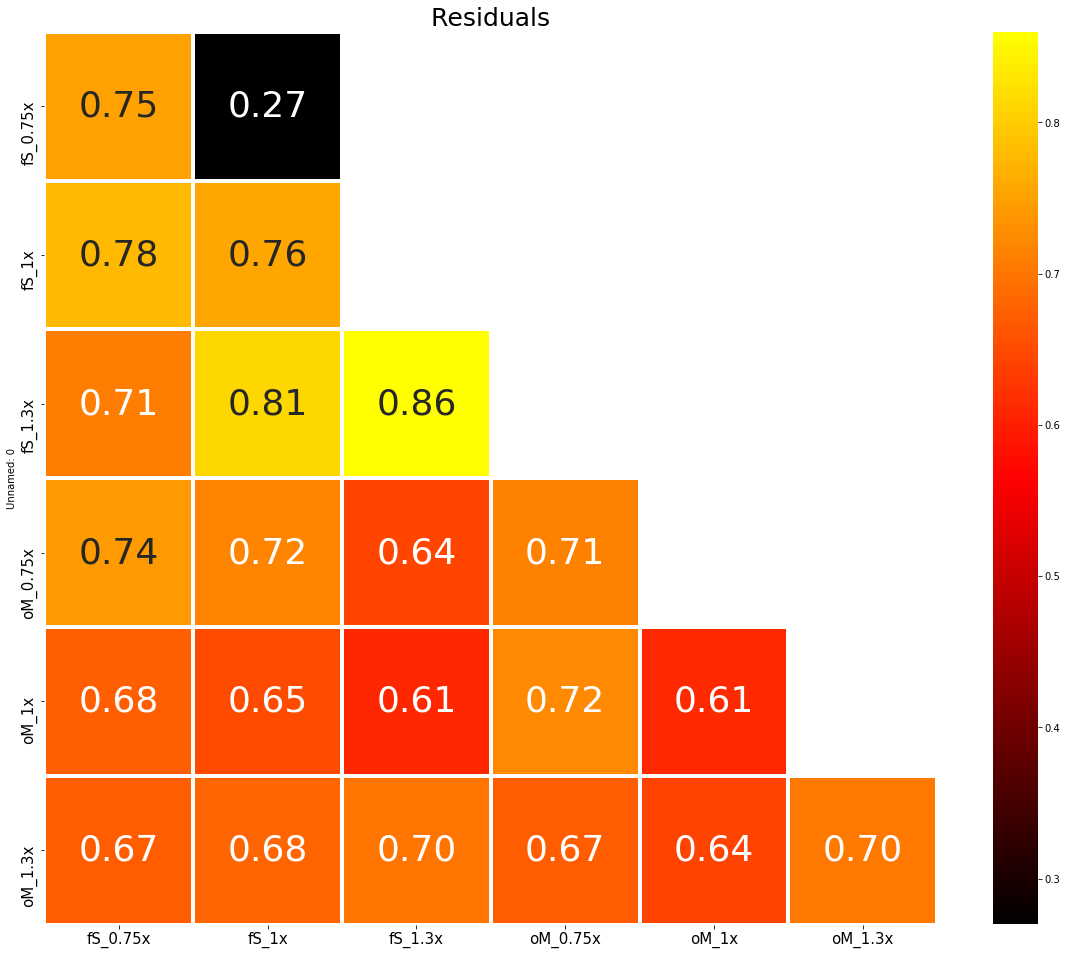

In [154]:

plt.figure(figsize=[12,12])

# Custom colormap from black to yellow
colors = ["black", "red", "yellow"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# Normalize the color mapping to start at 0.5 instead of 0
norm = mcolors.Normalize(vmin=0.5, vmax=1)

plt.figure(figsize=[20,20])

# Create the heatmap with normalization
ax = sns.heatmap(dur_collapsed_matrix, annot=True, fmt=".2f", cmap=cmap, norm=norm, square=True, edgecolors='w', linewidths=3, cbar_kws={"shrink": .82}, annot_kws={"size": 36})

# Adjust the axis limits if necessary
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust font size here

plt.title('Residuals', fontsize=25)

plt.savefig(fig_destination + '/residuals-matrix-v5.png', dpi=300)

plt.show();

### Object Familiarity Decoding Across Durations

In [53]:
corr_fS = df_replaced.loc[~df_replaced.index.str.contains('oM'), ~df_replaced.columns.str.contains('oM')]
corr_oM = df_replaced.loc[~df_replaced.index.str.contains('fS'), ~df_replaced.columns.str.contains('fS')]


In [54]:
fS_corr_mean = corr_fS.mean().mean()
oM_corr_mean = corr_oM.mean().mean()

print('Familiar Corr Average, Cuboid Corr Average')
print(fS_corr_mean, oM_corr_mean)

fS_corrs = corr_fS.values.flatten() 
fS_corrs_no_nans = fS_corrs[~np.isnan(fS_corrs)].tolist()

oM_corrs = corr_oM.values.flatten() 
oM_corrs_no_nans = oM_corrs[~np.isnan(oM_corrs)].tolist()

print()

print('Average Correlation: Within Object Familiarity Condition')
all_within_corrs = fS_corrs_no_nans + oM_corrs_no_nans

print(np.mean(np.array(all_within_corrs)))


Familiar Corr Average, Cuboid Corr Average
0.7715252858792488 0.6783772059960986

Average Correlation: Within Object Familiarity Condition
0.7249512459376738


In [55]:
# Remove columns containing 'fS'
between_cond_corrs = df_replaced.loc[:, ~df_replaced.columns.str.contains('fS')]
between_cond_corrs = between_cond_corrs[~between_cond_corrs.index.str.contains('oM')]

print('Average Correlation: Between Object Familiarity Condition')
print(between_cond_corrs.mean().mean())

Average Correlation: Between Object Familiarity Condition
0.6770799356101023


### Object Scale Decoding Across Durations

In [56]:
filtered_75x = df_replaced.filter(like='0.75x', axis=1)
filtered_75x = filtered_75x[filtered_75x.index.str.contains('0.75x')]

filtered_1x = df_replaced.filter(like='1x', axis=1)
filtered_1x = filtered_1x[filtered_1x.index.str.contains('1x')]

filtered_13x = df_replaced.filter(like='1.3x', axis=1)
filtered_13x = filtered_13x[filtered_13x.index.str.contains('1.3x')]


print('Average Correlation per Scale Condition: 0.75x, 1x, 1.3x')
print(filtered_75x.mean().mean(), filtered_1x.mean().mean(), filtered_13x.mean().mean())


corrs_75x = filtered_75x.values.flatten() 
corrs_75x_no_nans = corrs_75x[~np.isnan(corrs_75x)].tolist()

corrs_1x = filtered_1x.values.flatten() 
corrs_1x_no_nans = corrs_1x[~np.isnan(corrs_1x)].tolist()

corrs_13x = filtered_13x.values.flatten() 
corrs_13x_no_nans = corrs_13x[~np.isnan(corrs_13x)].tolist()

print()

print('Average Correlation: Within Object Scale Condition')
all_within_corrs_scale = corrs_75x_no_nans + corrs_1x_no_nans + corrs_13x_no_nans

print(np.mean(np.array(all_within_corrs_scale)))


Average Correlation per Scale Condition: 0.75x, 1x, 1.3x
0.7387294172140558 0.6636635881123915 0.7327757149993129

Average Correlation: Within Object Scale Condition
0.7117229067752534


In [57]:
# Function to remove cells where the last part of the string name matches for both row and column
def remove_matching_cells(df):
    for col in df.columns:
        for idx in df.index:
            # Splitting by '_' and comparing the last parts of the strings for both column and row names
            if col.split('_')[-1] == idx.split('_')[-1]:
                df.at[idx, col] = np.nan  
    return df

between_scale_df = remove_matching_cells(df_replaced)
# between_scale_df


print('Average Correlation: Between Object Scale Conditiosn')
print(between_scale_df.mean().mean())

Average Correlation: Between Object Scale Conditiosn
0.6945595711763369


## Summary Regression Plots

In [58]:
reg_dest = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/familiarSize/figures-presentations/figs/regressions'

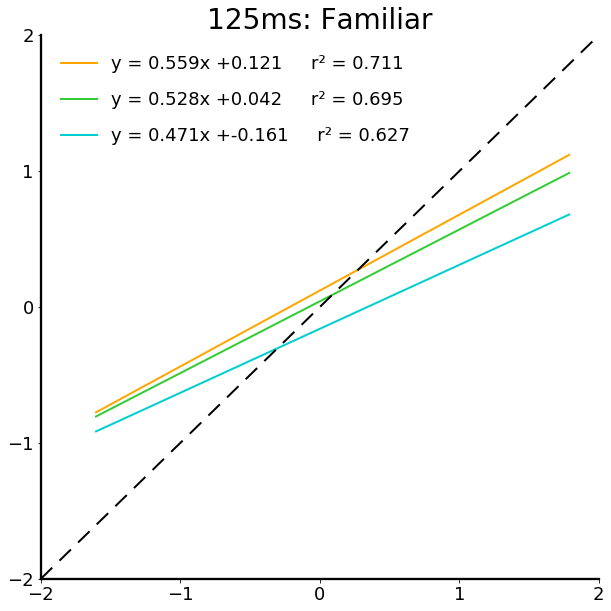

In [101]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
X = np.array(all_data['125_fS_0.75x']['actual_depth']).reshape(-1,1)
y = all_data['125_fS_0.75x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

plt.plot(X,y_predicted,color='orange', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)


X = np.array(all_data['125_fS_1x']['actual_depth']).reshape(-1,1)
y = all_data['125_fS_1x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

plt.plot(X,y_predicted,color='limegreen', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)

X = np.array(all_data['125_fS_1.3x']['actual_depth']).reshape(-1,1)
y = all_data['125_fS_1.3x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

plt.plot(X,y_predicted,color='darkturquoise', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)

dash_pattern = [8, 5]
plt.plot([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

plt.ylim(-2,2)
plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 1), fontsize=18)
plt.yticks(np.arange(-2, 2.5, 1), fontsize=18)


legend = plt.legend(loc = 2, fontsize = 18, borderpad = 0.6, labelspacing = 1, frameon=False)

plt.title('125ms: Familiar', fontsize=28)
# plt.xlabel("Z-Scored Actual Distance (m)", fontsize = 22)
# plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

plt.savefig(reg_dest + '/125ms-familiar', dpi=300)

plt.show();

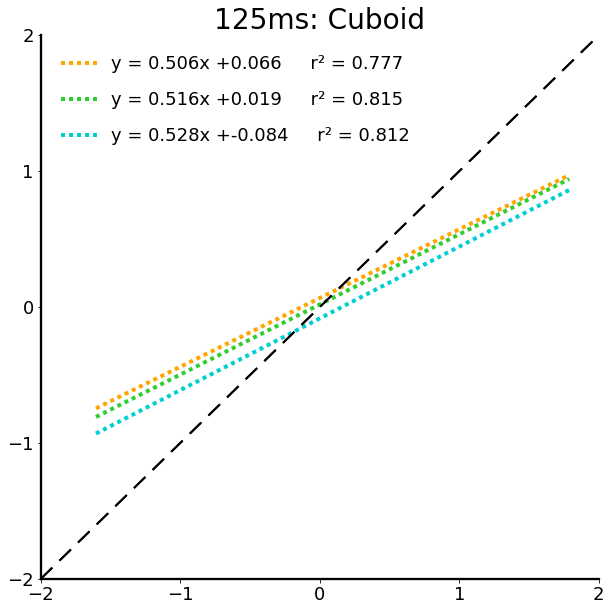

In [102]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
X = np.array(all_data['125_oM_0.75x']['actual_depth']).reshape(-1,1)
y = all_data['125_oM_0.75x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

plt.plot(X,y_predicted,color='orange', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linestyle=(0, (1, 1)), linewidth=4)


X = np.array(all_data['125_oM_1x']['actual_depth']).reshape(-1,1)
y = all_data['125_oM_1x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

plt.plot(X,y_predicted,color='limegreen', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linestyle=(0, (1, 1)), linewidth=4)

X = np.array(all_data['125_oM_1.3x']['actual_depth']).reshape(-1,1)
y = all_data['125_oM_1.3x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

plt.plot(X,y_predicted,color='darkturquoise', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linestyle=(0, (1, 1)),linewidth=4)

dash_pattern = [8, 5]
plt.plot([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

dash_pattern = [8, 5]
plt.plot([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

plt.ylim(-2,2)
plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 1), fontsize=18)
plt.yticks(np.arange(-2, 2.5, 1), fontsize=18)


legend = plt.legend(loc = 2, fontsize = 18, borderpad = 0.6, labelspacing = 1, frameon=False)

plt.title('125ms: Cuboid', fontsize=28)
# plt.xlabel("Z-Scored Actual Distance (m)", fontsize = 22)
# plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)
plt.savefig(reg_dest + '/125ms-cuboid', dpi=300)


plt.show();

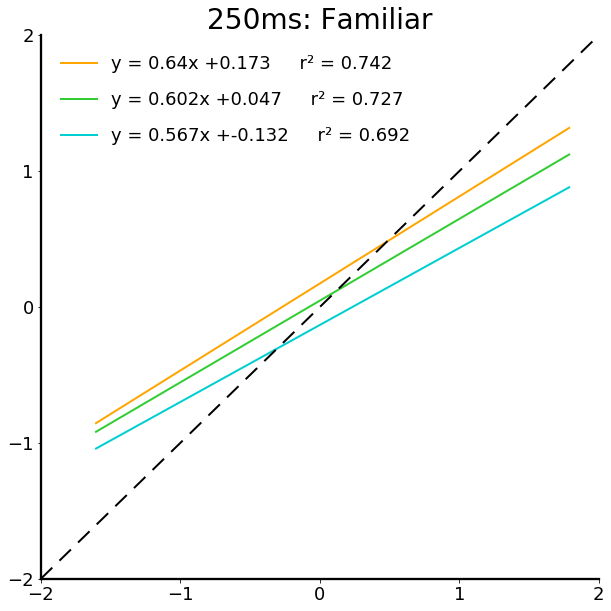

In [103]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
X = np.array(all_data['250_fS_0.75x']['actual_depth']).reshape(-1,1)
y = all_data['250_fS_0.75x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

plt.plot(X,y_predicted,color='orange', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)


X = np.array(all_data['250_fS_1x']['actual_depth']).reshape(-1,1)
y = all_data['250_fS_1x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

plt.plot(X,y_predicted,color='limegreen', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)

X = np.array(all_data['250_fS_1.3x']['actual_depth']).reshape(-1,1)
y = all_data['250_fS_1.3x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

plt.plot(X,y_predicted,color='darkturquoise', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)

dash_pattern = [8, 5]
plt.plot([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

plt.ylim(-2,2)
plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 1), fontsize=18)
plt.yticks(np.arange(-2, 2.5, 1), fontsize=18)


legend = plt.legend(loc = 2, fontsize = 18, borderpad = 0.6, labelspacing = 1, frameon=False)

plt.title('250ms: Familiar', fontsize=28)
# plt.xlabel("Z-Scored Actual Distance (m)", fontsize = 22)
# plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

plt.savefig(reg_dest + '/250ms-familiar', dpi=300)


plt.show();

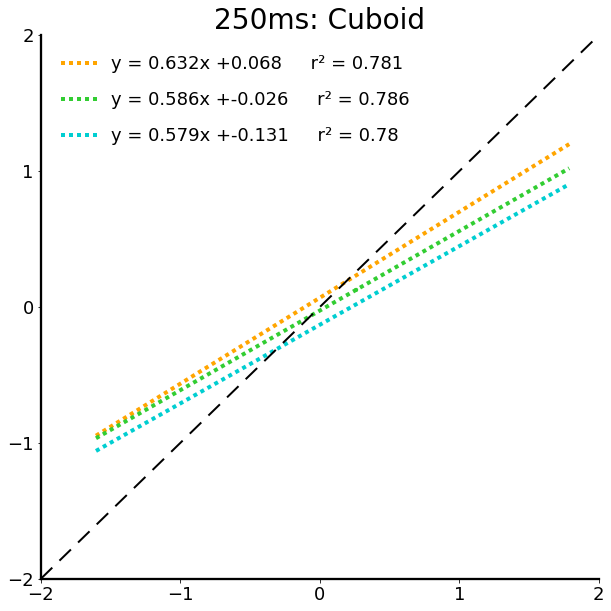

In [104]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
X = np.array(all_data['250_oM_0.75x']['actual_depth']).reshape(-1,1)
y = all_data['250_oM_0.75x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

plt.plot(X,y_predicted,color='orange', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linestyle=(0, (1, 1)), linewidth=4)


X = np.array(all_data['250_oM_1x']['actual_depth']).reshape(-1,1)
y = all_data['250_oM_1x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

plt.plot(X,y_predicted,color='limegreen', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linestyle=(0, (1, 1)), linewidth=4)

X = np.array(all_data['250_oM_1.3x']['actual_depth']).reshape(-1,1)
y = all_data['250_oM_1.3x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

plt.plot(X,y_predicted,color='darkturquoise', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linestyle=(0, (1, 1)),linewidth=4)

dash_pattern = [8, 5]
plt.plot([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

plt.ylim(-2,2)
plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 1), fontsize=18)
plt.yticks(np.arange(-2, 2.5, 1), fontsize=18)


legend = plt.legend(loc = 2, fontsize = 18, borderpad = 0.6, labelspacing = 1, frameon=False)

plt.title('250ms: Cuboid', fontsize=28)
# plt.xlabel("Z-Scored Actual Distance (m)", fontsize = 22)
# plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

plt.savefig(reg_dest + '/250ms-cuboid', dpi=300)


plt.show();

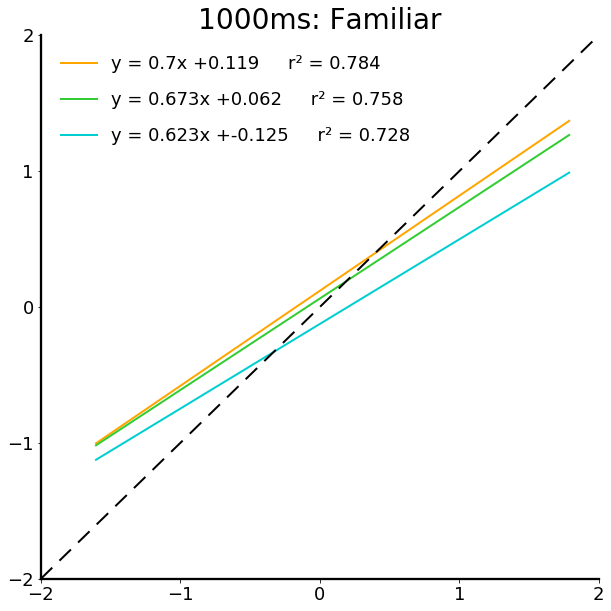

In [105]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
X = np.array(all_data['1000_fS_0.75x']['actual_depth']).reshape(-1,1)
y = all_data['1000_fS_0.75x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

plt.plot(X,y_predicted,color='orange', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)


X = np.array(all_data['1000_fS_1x']['actual_depth']).reshape(-1,1)
y = all_data['1000_fS_1x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

plt.plot(X,y_predicted,color='limegreen', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)

X = np.array(all_data['1000_fS_1.3x']['actual_depth']).reshape(-1,1)
y = all_data['1000_fS_1.3x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

plt.plot(X,y_predicted,color='darkturquoise', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linewidth=2)

dash_pattern = [8, 5]
plt.plot([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

plt.ylim(-2,2)
plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 1), fontsize=18)
plt.yticks(np.arange(-2, 2.5, 1), fontsize=18)


legend = plt.legend(loc = 2, fontsize = 18, borderpad = 0.6, labelspacing = 1, frameon=False)

plt.title('1000ms: Familiar', fontsize=28)
# plt.xlabel("Z-Scored Actual Distance (m)", fontsize = 22)
# plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)

plt.savefig(reg_dest + '/1000ms-familiar', dpi=300)


plt.show();

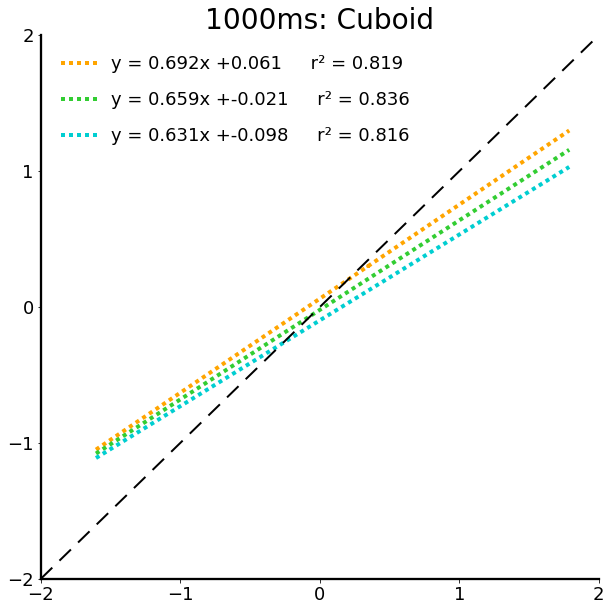

In [106]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)
    
X = np.array(all_data['1000_oM_0.75x']['actual_depth']).reshape(-1,1)
y = all_data['1000_oM_0.75x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

dash_pattern = [8, 5]
plt.plot(X,y_predicted,color='orange', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linestyle=(0, (1, 1)), linewidth=4)


X = np.array(all_data['1000_oM_1x']['actual_depth']).reshape(-1,1)
y = all_data['1000_oM_1x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

plt.plot(X,y_predicted,color='limegreen', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linestyle=(0, (1, 1)), linewidth=4)

X = np.array(all_data['1000_oM_1.3x']['actual_depth']).reshape(-1,1)
y = all_data['1000_oM_1.3x']['y']

reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)

plt.plot(X,y_predicted,color='darkturquoise', label = 'y = ' + str(round(reg.coef_[0], 3)) + 'x +' + str(round(reg.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(r2_score(y, y_predicted)), 3)), linestyle=(0, (1, 1)),linewidth=4)

dash_pattern = [8, 5]
plt.plot([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)

plt.ylim(-2,2)
plt.xlim(-2,2)

plt.xticks(np.arange(-2, 2.5, 1), fontsize=18)
plt.yticks(np.arange(-2, 2.5, 1), fontsize=18)


legend = plt.legend(loc = 2, fontsize = 18, borderpad = 0.6, labelspacing = 1, frameon=False)

# plt.xlabel("Z-Scored Actual Distance (m)", fontsize = 22)
# plt.ylabel("Z-Scored Estimated Distance (m)", fontsize = 22)
plt.title('1000ms: Cuboid', fontsize=28)

plt.savefig(reg_dest + '/1000ms-cuboid', dpi=300)


plt.show();

## Demographics + Other

In [5]:
MX_data = pd.concat([MX_data_125, MX_data_250, MX_data_1000])

### Screen Size

In [6]:
screenWidths = np.array(MX_data['screenWidth'])
screenHeights = np.array(MX_data['screenHeight'])

np.mean(screenWidths), np.std(screenWidths)

(1642.5102140267436, 333.1677306962316)

In [7]:
np.mean(screenHeights), np.std(screenHeights)

(944.8341585123387, 170.52911595712848)

### Time Taken

In [10]:
print(np.mean((np.array(MX_data['totalTime'])//1000)/60), np.std((np.array(MX_data['totalTime'])//1000)/60))

8.902204917287174 4.597369244555767


### Age

In [10]:
ages = []
for subj in MX_data.subjID.unique():
    subj_age = MX_data.loc[MX_data['subjID']==subj].age.unique()[0]
    if subj_age < 18:
        print(subj_age)
        pass
    else:
        if subj_age > 1900:
            print(subj_age)
            
    ages.append(subj_age)

np.mean(np.array(ages)), np.std(np.array(ages))

(28.76313079299691, 8.230680345633477)

In [11]:
np.min(ages), np.max(ages)

(18, 70)

### Gender

In [389]:
gender_dict_count = {}
for response in MX_data.gender.unique():
    gender_dict_count[response] = 0

gender_dict_count

{'Woman': 0,
 'Man': 0,
 'Transgender': 0,
 'Mujer': 0,
 'Transgender Woman': 0,
 'Donna': 0,
 'Mulher': 0,
 'Non-binary': 0,
 'Genderqueer': 0,
 'Człowiek': 0,
 'Prefer not to answer': 0,
 'Kobieta': 0,
 'Hombre': 0,
 'Homem': 0,
 'None of these describe me': 0,
 'WOMAN': 0}

In [390]:
translation_dict = {'Donna': 'Woman', 'Mujer': 'Woman', 'Mulher': 'Woman', 'Człowiek': 'Man', 'Kobieta': 'Woman', 'Hombre': 'Man', 'Homem': 'Man', 'WOMAN': 'Woman'}


In [392]:
gender_dict_count = {'Woman': 0,
                     'Man': 0,
                     'Transgender': 0,
                     'Transgender Woman': 0,
                     'Non-binary': 0,
                     'Genderqueer': 0,
                     'Prefer not to answer': 0,
                     'None of these describe me': 0}

for subj in MX_data.subjID.unique():
    subj_gender = MX_data.loc[MX_data['subjID']==subj].gender.unique()[0]
    if subj_gender in translation_dict.keys():
        translated_gender = translation_dict[subj_gender]
        gender_dict_count[translated_gender] += 1
    else:
        gender_dict_count[subj_gender] += 1

    

In [393]:
gender_dict_count

{'Woman': 491,
 'Man': 463,
 'Transgender': 3,
 'Transgender Woman': 1,
 'Non-binary': 10,
 'Genderqueer': 1,
 'Prefer not to answer': 1,
 'None of these describe me': 1}

## Keypress Analysis

In [159]:
keystrokes = [len(str(de)[:-2]) for de in list(MX_data['depth_estimate'])]


In [160]:
MX_data.insert(2, "keystrokes", keystrokes)

In [161]:
MX_data.to_csv('RT_data_for_lme.csv', index=False)